**Student Name:** Raymond Willey<br>
**Student Pace:** Self-Paced<br>
**Scheduled Project Review Date/Time:** Week of 5/20/19<br> 
**Instructor Name:** Eli Thomas<br>
**Vlog Post URL:** https://www.overloadblog.info/blog/a-rather-morbid-topic <br>
**Blog Post URL:** https://www.overloadblog.info/blog/measure-twice-cut-once

<a id='overview'></a>
# Top Causes of Death in the United States: Overview
Worldwide health organizations want to plan budgets and strategize according to national and localized trends. In this case, we are working with data from 1999-2016 which highlights the leading causes of death in the United States at the state level. Our fictional organization would like to know which states will be at the highest level of risk in 2019 so that they can appropriately allocate resources. 

<a id='q1'></a>
## What is the leading cause of death in the United States?
The [National Center for Health Statistics (NCHS)](https://data.cdc.gov/NCHS/NCHS-Leading-Causes-of-Death-United-States/bi63-dtpu) provides data on the leading causes of death in the United States on an annual basis for each state. The data has been retrieved via API, then saved to CSV and dataframe. All future reading of the data is pulled from the saved CSV file.

In [1]:
import time
T0 = time.time()

import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import io
import requests

# # Request data via http get, then save as CSV
# url="https://data.cdc.gov/resource/bi63-dtpu.csv"
# s=requests.get(url).content
# pd.read_csv(io.StringIO(s.decode('utf-8'))).to_csv('causes_of_death.csv')

# Create dataframe from CSV
raw_df = pd.read_csv('causes_of_death.csv')
raw_df.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,2755,55.5
1,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,439,63.1
2,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,4010,54.2
3,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,1604,51.8
4,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,California,13213,32.0


In [3]:
raw_df.shape

(10296, 6)

#### Initial Cleaning: Columns to Drop
* **113 Cause Name:** Long name for *Cause Name*, and not required.
* **Age-adjusted Death Rate:** Interested in number of deaths per capita. Ambiguity in how this number is calculated.
* **Aggregated Data:** Drop rows where the cause name is *All causes* and state is *United States*.

In [4]:
df = raw_df[(raw_df['Cause Name'] != 'All causes') & (raw_df['State'] != 'United States')]
df = df.drop(columns = ['113 Cause Name', 'Age-adjusted Death Rate'])
df = df.rename(columns={'Cause Name': 'Cause_Name'})
df.head()

,Year,Cause_Name,State,Deaths
0,2016,Unintentional injuries,Alabama,2755
1,2016,Unintentional injuries,Alaska,439
2,2016,Unintentional injuries,Arizona,4010
3,2016,Unintentional injuries,Arkansas,1604
4,2016,Unintentional injuries,California,13213


<a id='demographics'></a>
### State Size (Population) - Centers for Disease Control & Prevention
In order to properly assess number of deaths per capita, population data must also be incorporated. This data was also obtained from the [NCHS](https://wonder.cdc.gov/Bridged-Race-v2017.HTML) and saved locally to a .CSV file.

In [5]:
population = pd.read_csv('Bridged-Race Population Estimates 1999-2017.csv', nrows=36822)
population.head()

,Notes,Yearly July 1st Estimates,Yearly July 1st Estimates Code,State,State Code,Age Group,Age Group Code,Gender,Gender Code,Population
0,NaN,1999,1999,Alabama,1,< 1 year,1,Female,F,28712
1,NaN,1999,1999,Alabama,1,< 1 year,1,Male,M,30075
2,NaN,1999,1999,Alabama,1,1-4 years,4-Jan,Female,F,115715
3,NaN,1999,1999,Alabama,1,1-4 years,4-Jan,Male,M,120438
4,NaN,1999,1999,Alabama,1,5-9 years,9-May,Female,F,153779


#### Preprocessing 
Initial cleanup before joining with with main dataset.

##### Column Drops
* **Notes:** Mostly null values, no real value add.
* **Codes:** Prefer actual values (i.e. drop *Age Group Code* in favor of *Age Group*.<br>

##### Other Cleaning
* **Gender:** Set to boolean value to evaluate as **True** if *Male* or **False** if *Female*.

In [6]:
population = population.drop(columns=['Notes', 'Yearly July 1st Estimates Code', 'State Code', 'Age Group Code', 'Gender'])
population = population.rename(columns = {'Yearly July 1st Estimates': 'Year', 'Gender Code': 'Male'})
population['Male'] = population['Male'].replace(to_replace = {'F':0, 'M':1}).astype(bool)
population['Year'] = population['Year'].astype(int)
population.head()

,Year,State,Age Group,Male,Population
0,1999,Alabama,< 1 year,False,28712
1,1999,Alabama,< 1 year,True,30075
2,1999,Alabama,1-4 years,False,115715
3,1999,Alabama,1-4 years,True,120438
4,1999,Alabama,5-9 years,False,153779


#### Data Join
Demographic data will be relevant later, so in addition to population by state, gender and age percentages should also be joined with primary dataset.
1. Aggregate *Total Population* by State & Year
2. Aggregate *Male Population* by State & Year
3. Aggregate *Age Groups* by State & Year

In [7]:
tot_pop = population.groupby(['Year', 'State']).sum().reset_index().drop(columns=['Male'])
tot_pop.head()

,Year,State,Population
0,1999,Alabama,4430141
1,1999,Alaska,624779
2,1999,Arizona,5023823
3,1999,Arkansas,2651860
4,1999,California,33499204


In [8]:
add_pop_df = pd.merge(df, tot_pop, left_on=['Year', 'State'], right_on=['Year', 'State'])
add_pop_df.head()

,Year,Cause_Name,State,Deaths,Population
0,2016,Unintentional injuries,Alabama,2755,4860545
1,2016,Alzheimer's disease,Alabama,2507,4860545
2,2016,Cancer,Alabama,10419,4860545
3,2016,CLRD,Alabama,3326,4860545
4,2016,Diabetes,Alabama,1183,4860545


In [9]:
# Add male population
mf_df = population[population['Male'] == True]
mf_df = mf_df.groupby(['Year', 'State']).sum().reset_index().drop(columns=['Male'])
add_mf_df = pd.merge(add_pop_df, mf_df, 
                     left_on=['Year', 'State'], 
                     right_on=['Year', 'State'], 
                     suffixes=('_Total', '_Male'))
add_mf_df['Population_Male'] = add_mf_df['Population_Male'] / add_mf_df['Population_Total']
add_mf_df[add_mf_df['Cause_Name']=='Cancer'].head()

,Year,Cause_Name,State,Deaths,Population_Total,Population_Male
2,2016,Cancer,Alabama,10419,4860545,0.484347
12,2016,Cancer,Alaska,995,741522,0.523475
22,2016,Cancer,Arizona,11876,6908642,0.497096
32,2016,Cancer,Arkansas,6612,2988231,0.491298
42,2016,Cancer,California,59515,39296476,0.496812


In [10]:
# Add age groups
add_age_df = add_mf_df

for group in population['Age Group'].unique():
    age_df = population[population['Age Group'] == group]
    age_df = age_df.groupby(['Year', 'State']).sum().reset_index().drop(columns=['Male'])
    add_age_df = pd.merge(add_age_df, age_df,
                          left_on=['Year', 'State'], 
                          right_on=['Year', 'State'])
    add_age_df['Population'] = add_age_df['Population'] / add_age_df['Population_Total']
    add_age_df = add_age_df.rename(columns={'Population':f'Population_{group}'})
    
add_age_df[add_age_df['Year']==2016].head()

,Year,Cause_Name,State,Deaths,Population_Total,Population_Male,Population_< 1 year,Population_1-4 years,Population_5-9 years,Population_10-14 years,...,Population_40-44 years,Population_45-49 years,Population_50-54 years,Population_55-59 years,Population_60-64 years,Population_65-69 years,Population_70-74 years,Population_75-79 years,Population_80-84 years,Population_85+ years
0,2016,Unintentional injuries,Alabama,2755,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883
1,2016,Alzheimer's disease,Alabama,2507,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883
2,2016,Cancer,Alabama,10419,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883
3,2016,CLRD,Alabama,3326,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883
4,2016,Diabetes,Alabama,1183,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883


In [11]:
# Update column names so properly formatted for OLS functions
to_replace = {}
for col in add_age_df.columns:
    to_replace[col] = col.replace('-', '_').replace(' ', '_')

to_replace['Population_Total']='Population'
add_age_df = add_age_df.rename(columns=to_replace)
add_age_df.head()

,Year,Cause_Name,State,Deaths,Population,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,...,Population_40_44_years,Population_45_49_years,Population_50_54_years,Population_55_59_years,Population_60_64_years_,Population_65_69_years,Population_70_74_years,Population_75_79_years,Population_80_84_years,Population_85+_years
0,2016,Unintentional injuries,Alabama,2755,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883
1,2016,Alzheimer's disease,Alabama,2507,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883
2,2016,Cancer,Alabama,10419,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883
3,2016,CLRD,Alabama,3326,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883
4,2016,Diabetes,Alabama,1183,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.06043,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883


In [12]:
df = add_age_df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9180 entries, 0 to 9179
Data columns (total 25 columns):
Year                       9180 non-null int64
Cause_Name                 9180 non-null object
State                      9180 non-null object
Deaths                     9180 non-null int64
Population                 9180 non-null int64
Population_Male            9180 non-null float64
Population_<_1_year        9180 non-null float64
Population_1_4_years       9180 non-null float64
Population_5_9_years       9180 non-null float64
Population_10_14_years     9180 non-null float64
Population_15_19_years     9180 non-null float64
Population_20_24_years     9180 non-null float64
Population_25_29_years     9180 non-null float64
Population_30_34_years     9180 non-null float64
Population_35_39_years     9180 non-null float64
Population_40_44_years     9180 non-null float64
Population_45_49_years     9180 non-null float64
Population_50_54_years     9180 non-null float64
Population_55_59_ye

In [13]:
df.describe()

,Year,Deaths,Population,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,...,Population_40_44_years,Population_45_49_years,Population_50_54_years,Population_55_59_years,Population_60_64_years_,Population_65_69_years,Population_70_74_years,Population_75_79_years,Population_80_84_years,Population_85+_years
count,9180.00000,9180.000000,9.180000e+03,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,...,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000
mean,2007.50000,3725.386928,5.922638e+06,0.492744,0.013093,0.052031,0.066006,0.068364,0.070826,0.071147,...,0.070885,0.071844,0.069527,0.061433,0.050565,0.040257,0.031708,0.025216,0.018588,0.017429
std,5.18841,7161.711981,6.630446e+06,0.008032,0.001638,0.005692,0.006493,0.006569,0.005591,0.006880,...,0.008318,0.006685,0.005873,0.008606,0.009434,0.007808,0.004743,0.003801,0.003211,0.004130
min,1999.00000,21.000000,4.917800e+05,0.470729,0.009192,0.038622,0.042565,0.038807,0.053589,0.054894,...,0.052107,0.051264,0.046077,0.035254,0.027146,0.019557,0.015225,0.010444,0.005645,0.003939
25%,2003.00000,526.000000,1.594673e+06,0.487133,0.012156,0.048646,0.062667,0.064769,0.066981,0.067824,...,0.064079,0.067665,0.065940,0.054970,0.042620,0.034698,0.029207,0.023603,0.016914,0.014704
50%,2007.50000,1401.500000,4.131636e+06,0.491545,0.013024,0.051847,0.066178,0.068489,0.070818,0.070614,...,0.070497,0.072660,0.069626,0.062753,0.050072,0.038503,0.031518,0.025338,0.018758,0.017298
75%,2012.00000,3228.250000,6.706435e+06,0.497155,0.013941,0.055125,0.069421,0.072435,0.073654,0.073300,...,0.077739,0.076105,0.073108,0.067628,0.058326,0.045277,0.034179,0.027176,0.020458,0.020401
max,2016.00000,71930.000000,3.929648e+07,0.523698,0.020272,0.077162,0.090231,0.090548,0.099466,0.104689,...,0.094693,0.088377,0.086697,0.082902,0.076172,0.068138,0.048455,0.038807,0.026185,0.027776


<a id='q1results'></a>
### Group Data by Top Causes of Death & Inspect Results

In [14]:
top_causes = df[['Deaths', 'Population']].groupby(df['Cause_Name']).sum()
top_causes['Deaths_per_Capita'] = top_causes['Deaths'] / top_causes['Population']
top_causes

,Deaths,Population,Deaths_per_Capita
Cause_Name,,,
Alzheimer's disease,1373412,5436981948,0.000253
CLRD,2434726,5436981948,0.000448
Cancer,10244536,5436981948,0.001884
Diabetes,1316379,5436981948,0.000242
Heart disease,11575183,5436981948,0.002129
Influenza and pneumonia,1038969,5436981948,0.000191
Kidney disease,807980,5436981948,0.000149
Stroke,2580140,5436981948,0.000475
Suicide,649843,5436981948,0.000120


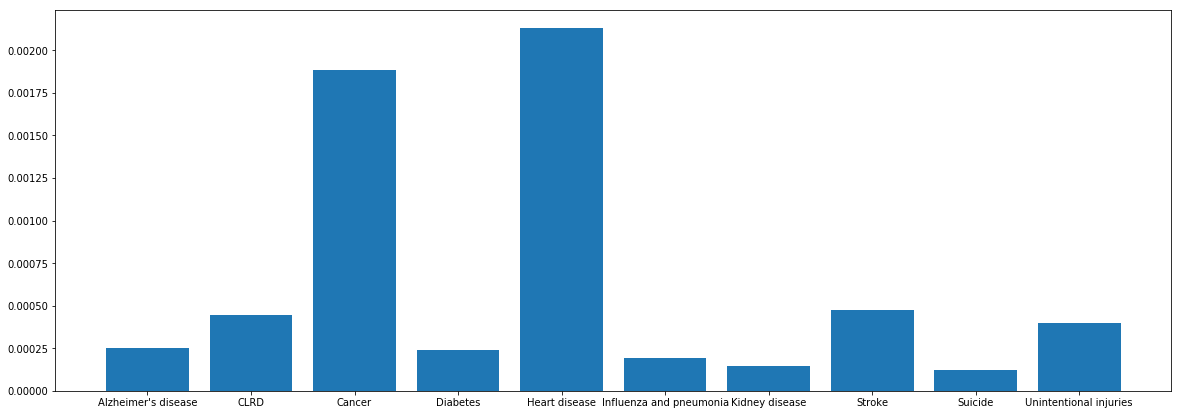

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))
plt.bar(top_causes.index, top_causes['Deaths_per_Capita'])
plt.show()

Leading causes of **Deaths_per_Capita** are **Heart Disease** and **Cancer**, and with heart disease slightly ahead. To determine if the difference in death rates between these causes is significant, a 2 tail F-Test for difference in population means will need to be performed.

### Hypothesis Testing
The following functions create visualizations and return the results for a 2-tail F-Test comparing population means.

In [16]:
def dist_plot(control, test, ctrl_label='Control Group', test_label='Test Group'):
    # Create a distribution plot to compare control and test groups for hypothesis testing
    plt.figure(figsize=(8, 8))
    sns.distplot(control, color='red', label=ctrl_label)
    sns.distplot(test, color='blue', label=test_label)
    plt.legend()
    plt.show()

In [17]:
from __future__ import print_function, division
import scipy.stats

def evaluate_PDF(rv, x=4):
    '''Input: a random variable object, standard deviation
       output : x and y values for the normal distribution
       '''
    
    # Identify the mean and standard deviation of random variable 
    mean = rv.mean()
    std = rv.std()

    # Use numpy to calculate evenly spaced numbers over the specified 
    # interval (4 sd) and generate 100 samples.
    xs = np.linspace(mean - x*std, mean + x*std, 100)
    
    # Calculate the peak of normal distribution i.e. probability density. 
    ys = rv.pdf(xs)

    return xs, ys # Return calculated values

In [18]:
def norm_dist(control, test, ctrl_label='Control Group', test_label='Test Group'):
    # Evaluate the PDF's of control and test groups and generate 
    # normal distributions to visualize the mean and variance differences
    control_mean, control_std = np.mean(control), np.std(control)
    control_quant = scipy.stats.norm(control_mean, control_std)

    test_mean, test_std = np.mean(test), np.std(test)
    test_quant = scipy.stats.norm(test_mean, test_std)
    
    plt.figure(figsize=(8, 8))

    xs, ys = evaluate_PDF(control_quant)
    plt.plot(xs, ys, label=ctrl_label, linewidth=4, color='red')
    plt.axvline(x=control_mean, color='red', ls='-.', label=f'{ctrl_label} Mean: {np.round(control_mean, 4)}')

    xs, ys = evaluate_PDF(test_quant)
    plt.plot(xs, ys, label=test_label, linewidth=4, color='blue') 
    plt.axvline(x=test_mean, color='blue', ls='-.', label=f'{test_label} Mean: {np.round(test_mean, 4)}')

    plt.xlabel('Death Rate')
    plt.legend()
    plt.show()


In [19]:
from scipy import stats

def test_results(control, test):
    return stats.ttest_ind(test, control)

In [20]:
def get_results(control, test, ctrl_label='Control Label', test_label='Test Label', conf_lvl = .95):
    # Determine if the mean differences between control and test groups are statistically significant
    # If so, display results & distribution plots, evaluate the PDF's, and provide normal distribution visualizations
    
    ctrl_mean, ctrl_std = np.mean(control), np.std(control)
    test_mean, test_std = np.mean(test), np.std(test)
    
    mean_diff = (test_mean - ctrl_mean) / ctrl_mean
    std_diff = (test_std - ctrl_std) / ctrl_std
    
    t_stat, p_val = test_results(control, test)
    
#   Print all key metrics for the test group if results are statistically significant, along with relevant plots.
#   Otherwise, indicate that the results are not significant at the given confidence level.
    print(f'Key Metrics for {test_label}')    
    if p_val < (1-conf_lvl):
        print(f'  {ctrl_label} Mean: {np.round(ctrl_mean, 6)}')
        print(f'  {test_label} Mean: {np.round(test_mean, 6)}')
        print(f'  Percent Mean Difference: {np.round(100 * mean_diff, 2)}%\n')
        print(f'  {ctrl_label} Std Dev: {np.round(ctrl_std, 6)}')
        print(f'  {test_label} Std Dev: {np.round(test_std, 6)}')
        print(f'  Percent Std Dev Difference: {np.round(100 * std_diff, 2)}%')
        print(f'  Test Statistic: {np.round(t_stat, 4)}')
        print(f'  P-Value: {p_val}')
        dist_plot(control, test, ctrl_label=ctrl_label, test_label=test_label)
        norm_dist(control, test, ctrl_label=ctrl_label, test_label=test_label)
    else:
        print(f'{test_label} Not Significant at {np.round(100*conf_lvl, 2)}% Confidence Level\n')
        
#   Regardless of significance, return the key statistics to a dictionary for evaluation.
    keys = ['Ctrl Mean', 'Ctrl Std', 'Test Mean', 'Test Std', 'Mean Diff', 'Std Diff', 't-stat', 'p_val']   
    values = [ctrl_mean, ctrl_std, test_mean, test_std, mean_diff, std_diff, t_stat, p_val]
    return dict(zip(keys, values))

In [21]:
causes = df['Cause_Name'].value_counts().index

### Create Dataframes to Compare Cancer to Heart Disease

In [22]:
cancer = df[df['Cause_Name'] == 'Cancer'][['Deaths', 'Population']].groupby(df['Year']).sum()
cancer['Deaths_per_Capita'] = cancer['Deaths'] / cancer['Population']
cancer = cancer.drop(columns = ['Deaths', 'Population'])

hd = df[df['Cause_Name'] == 'Heart disease'][['Deaths', 'Population']].groupby(df['Year']).sum()
hd['Deaths_per_Capita'] = hd['Deaths'] / hd['Population']
hd = hd.drop(columns = ['Deaths', 'Population'])

hd

,Deaths_per_Capita
Year,
1999,0.002599
2000,0.002519
2001,0.002457
2002,0.002423
2003,0.002361
2004,0.002228
2005,0.002207
2006,0.002117
2007,0.002045


In [23]:
cancer.head()

,Deaths_per_Capita
Year,
1999,0.001970
2000,0.001960
2001,0.001943
2002,0.001937
2003,0.001920


Key Metrics for Heart Disease
  Cancer Mean: 0.001886
  Heart Disease Mean: 0.002139
  Percent Mean Difference: 13.4%

  Cancer Std Dev: 4.1e-05
  Heart Disease Std Dev: 0.000229
  Percent Std Dev Difference: 466.01%
  Test Statistic: 4.4751
  P-Value: 8.141904785739937e-05


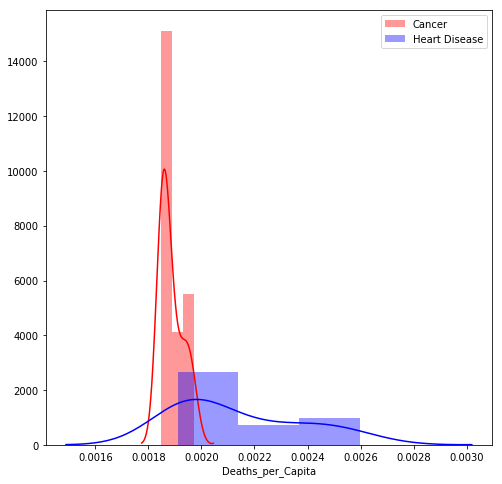

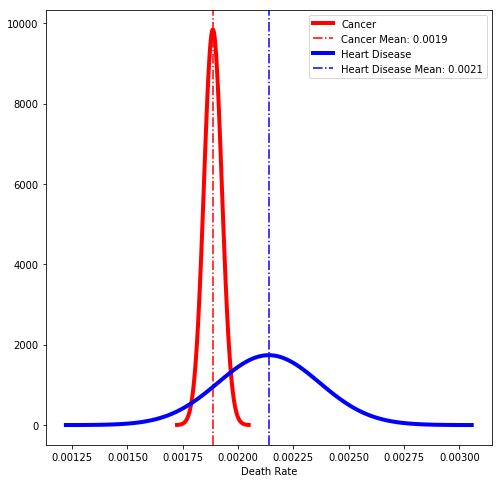

In [24]:
import numpy as np
import seaborn as sns

cancer_hd_results = get_results(cancer['Deaths_per_Capita'], hd['Deaths_per_Capita'], ctrl_label = 'Cancer', test_label='Heart Disease')

P-Value less than 0.000% indicates that there a statistically significant difference in means between heart disease and cancer. The difference in means is 13.4%. Furthermore, a difference in variance of 466% indicates cancer rates are much more consistent than those of heart disease. This suggests that rates in heart disease are more likely to influenced by external factors as opposed to specific demographics.

<a id='q2'></a>
### Compare Heart Disease Rates in 1999 & 2016 to Determine if Death Rates have Changed Significantly

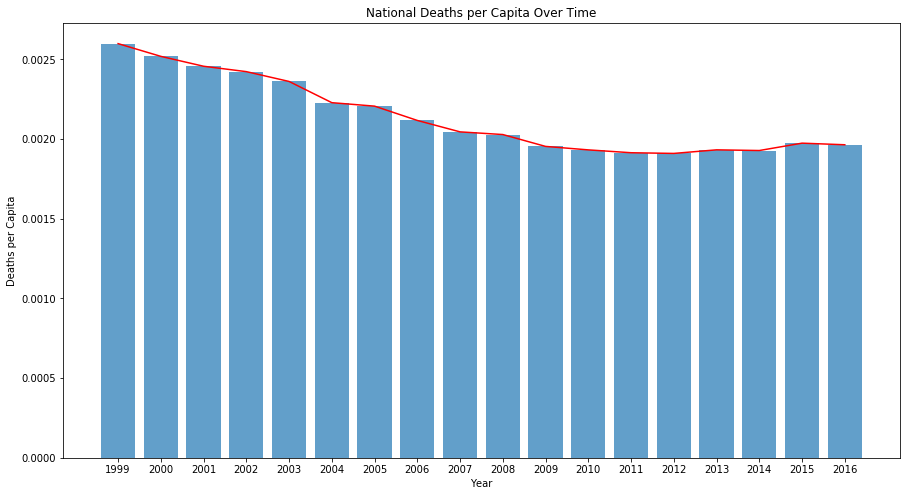

In [25]:
fig = plt.figure(figsize=(15, 8))
ax = fig.gca()

xs = hd.index
ys = hd['Deaths_per_Capita']

ax.bar(xs, ys, alpha=.7)
ax.plot(xs, ys, color='r')

plt.xticks(list(range(1999, 2017, 1)))
plt.xlabel('Year')
plt.ylabel('Deaths per Capita')
plt.title('National Deaths per Capita Over Time')

plt.show()

Key Metrics for Heart Disease 2016
  Heart Disease 1999 Mean: 0.002537
  Heart Disease 2016 Mean: 0.002005
  Percent Mean Difference: -20.98%

  Heart Disease 1999 Std Dev: 0.000547
  Heart Disease 2016 Std Dev: 0.000373
  Percent Std Dev Difference: -31.79%
  Test Statistic: -5.682
  P-Value: 1.3157447549025112e-07


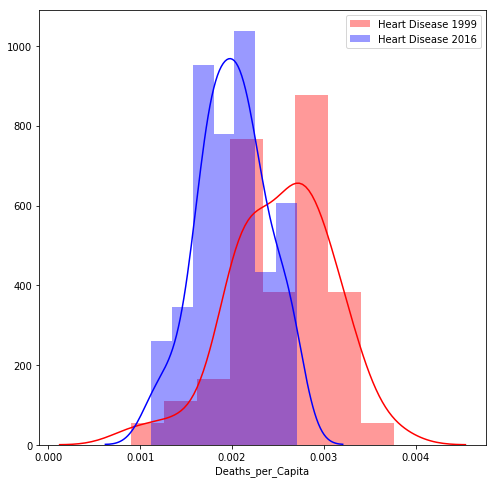

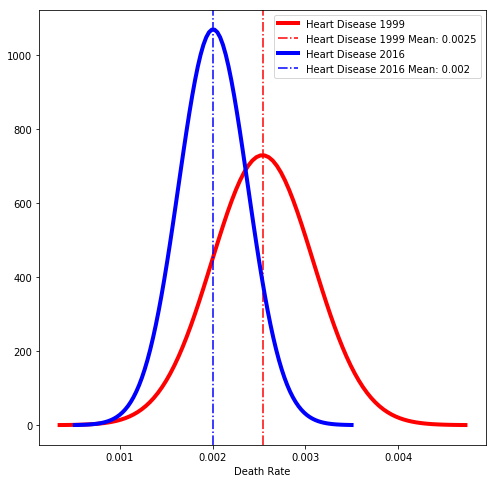

In [26]:
hd_yoy = df[df['Cause_Name'] == 'Heart disease'][['Year', 'State', 'Deaths', 'Population']]
hd_yoy['Deaths_per_Capita'] = hd_yoy['Deaths'] / hd_yoy['Population']

hd1999 = hd_yoy[hd_yoy['Year'] == 1999]['Deaths_per_Capita']
hd2016 = hd_yoy[hd_yoy['Year'] == 2016]['Deaths_per_Capita']

hd_results = get_results(hd1999, hd2016, ctrl_label = 'Heart Disease 1999', test_label='Heart Disease 2016', conf_lvl=.95)

Given a P-Value less than 0.000, with a difference in means of 20.98%, we can safely conclude that the rate of heart disease deaths has significantly decreased since 1999. While this does not alone take into account variances with regard to state size, it is consistent with the national trend, suggesting state by state variance is not a significant factor.

<a id='q3'></a>
## Which factors have the greatest impact on heart disease deaths?
### Factors Considered
* Population Density
* Age Demographic (already incorporated into dataset)
* Gender Demographic (already incorporated into dataset)
* Alcohol Consumption
* Smoking Population
* Diabetes Rates

First step is to create a dataframe that focused explicitly on Heart Disease

In [27]:
hd_df = df[df['Cause_Name'] == 'Heart disease']
hd_df.head()

,Year,Cause_Name,State,Deaths,Population,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,...,Population_40_44_years,Population_45_49_years,Population_50_54_years,Population_55_59_years,Population_60_64_years_,Population_65_69_years,Population_70_74_years,Population_75_79_years,Population_80_84_years,Population_85+_years
5,2016,Heart disease,Alabama,12832,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.060430,0.064118,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883
15,2016,Heart disease,Alaska,831,741522,0.523475,0.015050,0.058669,0.070705,0.066666,...,0.057997,0.060710,0.066038,0.068670,0.060097,0.044579,0.027017,0.015993,0.009482,0.008518
25,2016,Heart disease,Arizona,11957,6908642,0.497096,0.012329,0.050750,0.065835,0.066415,...,0.059608,0.060917,0.061377,0.062278,0.057501,0.055497,0.042170,0.030191,0.019872,0.019288
35,2016,Heart disease,Arkansas,8090,2988231,0.491298,0.012787,0.051212,0.065790,0.065944,...,0.059404,0.061214,0.065482,0.066091,0.060369,0.054650,0.040212,0.029202,0.019792,0.019157
45,2016,Heart disease,California,61573,39296476,0.496812,0.012455,0.050776,0.064575,0.064177,...,0.064037,0.066348,0.065988,0.064115,0.055368,0.046224,0.032182,0.022775,0.016168,0.018349


<a id='density'></a>
#### 1. Population Density
Data related to state, geographical area initially scraped from [State Symbols USA](https://statesymbolsusa.org/symbol-official-item/national-us/uncategorized/states-size), then saved to .CSV to prevent need for future scraping

In [28]:
from bs4 import BeautifulSoup
import requests

state_sizes = []

url = 'https://statesymbolsusa.org/symbol-official-item/national-us/uncategorized/states-size'
html_page = requests.get(url) #Make a get request to retrieve the page
soup = BeautifulSoup(html_page.content, 'html.parser') #Pass the page contents to beautiful soup for parsing

state_sizes = soup.find_all('td')

In [29]:
state_sizes[:10]

[<td> </td>,
 <td><strong>State</strong></td>,
 <td><strong>Square Miles (Land Area)</strong></td>,
 <td>1</td>,
 <td>Alaska</td>,
 <td>570,641</td>,
 <td>2</td>,
 <td>Texas</td>,
 <td>261,914</td>,
 <td>3</td>]

In [30]:
# Save relevant data to dictionary and create dataframe
state_data = state_sizes[3:]
states_dict = {'State':[], 'Square Miles (Land Area)':[]}

for i in range(int(len(state_data)/3)):
    states_dict['State'].append(state_data[i*3 + 1].text)
    states_dict['Square Miles (Land Area)'].append(float(state_data[i*3 + 2].text.replace(',', '')))

# Manually enter data for District of Columbia from Google Maps
states_dict['State'].append('District of Columbia')
states_dict['Square Miles (Land Area)'].append(68.34)
state_sizes = pd.DataFrame.from_dict(states_dict)
state_sizes.head()

,State,Square Miles (Land Area)
0,Alaska,570641.0
1,Texas,261914.0
2,California,155973.0
3,Montana,145556.0
4,New Mexico,121365.0


In [31]:
# Save dataframe to csv
state_sizes.to_csv('state_sizes.csv')

In [32]:
state_sizes = pd.read_csv('state_sizes.csv')
state_sizes = state_sizes[state_sizes.columns[1:]]
state_sizes = state_sizes.rename(columns = {'Square Miles (Land Area)': 'Sq_Miles'})
state_sizes.head()

,State,Sq_Miles
0,Alaska,570641.0
1,Texas,261914.0
2,California,155973.0
3,Montana,145556.0
4,New Mexico,121365.0


In [33]:
hd_df = pd.merge(hd_df, state_sizes, left_on=['State'], right_on=['State'])
hd_df['Pop_Density'] = hd_df['Population'] / hd_df['Sq_Miles']
hd_df.head()

,Year,Cause_Name,State,Deaths,Population,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,...,Population_50_54_years,Population_55_59_years,Population_60_64_years_,Population_65_69_years,Population_70_74_years,Population_75_79_years,Population_80_84_years,Population_85+_years,Sq_Miles,Pop_Density
0,2016,Heart disease,Alabama,12832,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883,50750.0,95.774286
1,2015,Heart disease,Alabama,12981,4850858,0.484665,0.012179,0.048409,0.062936,0.063828,...,0.070043,0.069515,0.061801,0.053638,0.038927,0.027938,0.018973,0.017619,50750.0,95.583409
2,2014,Heart disease,Alabama,12461,4840037,0.484787,0.012057,0.048594,0.063281,0.064846,...,0.071178,0.069157,0.060680,0.051657,0.038005,0.027491,0.018777,0.017302,50750.0,95.370187
3,2013,Heart disease,Alabama,12472,4827660,0.484981,0.011886,0.049125,0.063570,0.065616,...,0.071612,0.068900,0.059918,0.049688,0.036849,0.026860,0.018685,0.016942,50750.0,95.126305
4,2012,Heart disease,Alabama,12036,4813946,0.485060,0.012156,0.049996,0.063502,0.066419,...,0.072093,0.068041,0.059722,0.048072,0.035264,0.026260,0.018758,0.016657,50750.0,94.856079


<a id='alcohol'></a>
#### 2. Alcohol Consumption
Data scraped from the [National Institute on Alcohol Abuse and Alcoholism](https://pubs.niaaa.nih.gov/publications/surveillance110/tab4-1_16.htm). Data exists across 16 different pages for which each needed to be individually scraped. Data saved to CSV to prevent need for further scraping should site structure change.

Results indicate the total gallons of alcohol consumed per capita for wine, spirit, and beer consumption are based on sales data and percentage of the population that is 14 years and older. 

**Note: results do not show total gallons of alcohol type consumed, but amount of alcohol consumed from the given type. For example, 750ml of a liquor that is 50% alcohol results in 375ml of alcohol consumed.**

In [34]:
from bs4 import BeautifulSoup
import requests

years = []
datagray = []
data = []
states = []

for i in range(1, 17, 1):
    print(f'Page {i} of 16 ({100 * i/16:.2f}% Complete)')
    url = f'https://pubs.niaaa.nih.gov/publications/surveillance110/tab4-{i}_16.htm'
    html_page = requests.get(url) #Make a get request to retrieve the page
    soup = BeautifulSoup(html_page.content, 'html.parser') #Pass the page contents to beautiful soup for parsing
    
    states += soup.find_all('strong')
    years += soup.find_all('th', class_='stubs')
    
    # td represents table data, with class given by shading
    # Beer & spirits exist are the first two gray shaded columns, while wine & all beverages are the first two unshaded columns
    datagray += soup.find_all('td', class_='datagray')
    data += soup.find_all('td', class_='data')

Page 1 of 16 (6.25% Complete)
Page 2 of 16 (12.50% Complete)
Page 3 of 16 (18.75% Complete)
Page 4 of 16 (25.00% Complete)
Page 5 of 16 (31.25% Complete)
Page 6 of 16 (37.50% Complete)
Page 7 of 16 (43.75% Complete)
Page 8 of 16 (50.00% Complete)
Page 9 of 16 (56.25% Complete)
Page 10 of 16 (62.50% Complete)
Page 11 of 16 (68.75% Complete)
Page 12 of 16 (75.00% Complete)
Page 13 of 16 (81.25% Complete)
Page 14 of 16 (87.50% Complete)
Page 15 of 16 (93.75% Complete)
Page 16 of 16 (100.00% Complete)


In [35]:
# Drop table names stored in with same tag as state name
state_txt = []
for state in states:
    if state.text != 'Table 4.':
        state_txt.append(state.text)       
state_txt[:5]

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California']

In [36]:
# Save content to dictionary for conversion to dataframe
alcohol = {'State':[], 'Year':[], 'beer':[], 'wine':[], 'spirits':[], 'all_bevs': []}

for i in range(len(years)):
    # New state every 40 years
    # 3 datagray items for each year, 2 data items for each year
    alcohol['Year'].append(years[i].text) 
    alcohol['State'].append(state_txt[int(i/40)])
    alcohol['beer'].append(datagray[i*3].text)
    alcohol['wine'].append(data[i*2].text)
    alcohol['spirits'].append(datagray[i*3 + 1].text)
    alcohol['all_bevs'].append(data[i*2 + 1].text)

In [37]:
# Convert dictionary to dataframe and save as CSV to prevent need for future scraping
alcohol_df = pd.DataFrame.from_dict(alcohol)

alcohol_df['Year'] = alcohol_df['Year'].astype(int)
for k in list(alcohol.keys())[2:]:
    alcohol_df[k] = alcohol_df[k].astype(float)

alcohol_df.to_csv('alcohol_df.csv')
alcohol_df.head()

,State,Year,beer,wine,spirits,all_bevs
0,Alabama,2016,1.09,0.26,0.65,2.01
1,Alabama,2015,1.11,0.26,0.64,2.01
2,Alabama,2014,1.13,0.25,0.62,2.00
3,Alabama,2013,1.14,0.25,0.60,1.99
4,Alabama,2012,1.16,0.24,0.60,2.00


In [38]:
# Read data from CSV
alcohol_df = pd.read_csv('alcohol_df.csv', index_col=0)
alcohol_df.describe()

,Year,beer,wine,spirits,all_bevs
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1996.500000,1.287589,0.341455,0.845817,2.475192
std,11.545974,0.226351,0.179546,0.349340,0.613162
min,1977.000000,0.630000,0.080000,0.360000,1.190000
25%,1986.750000,1.130000,0.210000,0.640000,2.120000
50%,1996.500000,1.280000,0.310000,0.765000,2.360000
75%,2006.250000,1.410000,0.450000,0.950000,2.700000
max,2016.000000,2.170000,1.190000,3.560000,6.320000


In [39]:
alcohol_df.head()

,State,Year,beer,wine,spirits,all_bevs
0,Alabama,2016,1.09,0.26,0.65,2.01
1,Alabama,2015,1.11,0.26,0.64,2.01
2,Alabama,2014,1.13,0.25,0.62,2.00
3,Alabama,2013,1.14,0.25,0.60,1.99
4,Alabama,2012,1.16,0.24,0.60,2.00


In [40]:
hd_df = df[df['Cause_Name'] == 'Heart disease']
hd_df = pd.merge(hd_df, state_sizes, left_on=['State'], right_on=['State'])
hd_df['Pop_Density'] = hd_df['Population'] / hd_df['Sq_Miles']

hd_df = pd.merge(hd_df, alcohol_df, left_on=['State', 'Year'], right_on=['State', 'Year'] )
hd_df.head()

,Year,Cause_Name,State,Deaths,Population,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,...,Population_70_74_years,Population_75_79_years,Population_80_84_years,Population_85+_years,Sq_Miles,Pop_Density,beer,wine,spirits,all_bevs
0,2016,Heart disease,Alabama,12832,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.039662,0.028487,0.019281,0.017883,50750.0,95.774286,1.09,0.26,0.65,2.01
1,2015,Heart disease,Alabama,12981,4850858,0.484665,0.012179,0.048409,0.062936,0.063828,...,0.038927,0.027938,0.018973,0.017619,50750.0,95.583409,1.11,0.26,0.64,2.01
2,2014,Heart disease,Alabama,12461,4840037,0.484787,0.012057,0.048594,0.063281,0.064846,...,0.038005,0.027491,0.018777,0.017302,50750.0,95.370187,1.13,0.25,0.62,2.00
3,2013,Heart disease,Alabama,12472,4827660,0.484981,0.011886,0.049125,0.063570,0.065616,...,0.036849,0.026860,0.018685,0.016942,50750.0,95.126305,1.14,0.25,0.60,1.99
4,2012,Heart disease,Alabama,12036,4813946,0.485060,0.012156,0.049996,0.063502,0.066419,...,0.035264,0.026260,0.018758,0.016657,50750.0,94.856079,1.16,0.24,0.60,2.00


<a id='smoke'></a>
#### 3. Smoking
This multi-purpose dataset from the [United Health Foundation](https://www.americashealthrankings.org/explore/annual/measure/Smoking/state/ALL) includes smoking rates for each state. Each year is saved as a separate csv.

*Results represent percentage of population that have smoked at least 100 cigarettes in their lifetime.*

In [41]:
# Create initial dataframe for 1999 data
smoking = pd.read_csv('smoking/1999-Annual.csv')

# Append data for each initial year
for i in range(2000, 2017):
    smoke_yr = pd.read_csv(f'smoking/{str(i)}-Annual.csv')
    smoking = smoking.append(smoke_yr)

# Show results relevant to smoking and drop rows where national data is aggregated
smoking = smoking[(smoking['Measure Name'] == 'Smoking') & (smoking['State Name'] != 'United States')] 
smoking['Year'] = smoking['Report Type'].astype(str).str[:4].astype(int)
smoking = smoking[['Year', 'State Name', 'Value']].reset_index(drop=True)
smoking['Value'] = smoking['Value'].astype(float)
smoking = smoking.rename(columns = {'State Name': 'State'})
smoking.head()

,Year,State,Value
0,1999,Alabama,24.6
1,1999,Alaska,26.1
2,1999,Arizona,21.8
3,1999,Arkansas,25.9
4,1999,California,19.2


In 2012, the methodology for determining smoking rates changed, resulting in a spike for 2012 data and beyond. Because we are more interested in the change in smoking rates from year to year rather than the exact rate itself, all values in 2012 and after must be scaled to align with prior year methodologies.

**Key Assumption: Geometric mean of year-over-year changes for 2006-2011 used to adjust 2012 rates and beyond.**

In [42]:
state_list = smoking['State'].unique()

state_adjs = {}
est_adjs = []

# Calculate 2012 percentage adjustment for each state and save to dictionary
for st in state_list:
    prev = smoking['Value'][(smoking['State'] == st) & (smoking['Year']==2006)].values[0]
    new = smoking['Value'][(smoking['State'] == st) & (smoking['Year']==2011)].values[0]
    cur = smoking['Value'][(smoking['State'] == st) & (smoking['Year']==2012)].values[0]
    new_val = new * (new / prev) ** .2
    adj = new_val / cur
    state_adjs[st] = adj

# 2012 adjustment calculation applied to each period thereafter, otherwise set to 1 (no adjustment)
for yr, st in zip(smoking['Year'], smoking['State']):
    est_adjs.append(1) if yr <= 2011 else est_adjs.append(state_adjs[st])

# Add adjustment calculations and adjusted values to smoking dataframe
smoking['Estimated Adjustment'] = est_adjs
smoking['Adjusted Value'] = smoking['Value'] * smoking['Estimated Adjustment']
smoking[smoking['State'] == 'New York']

,Year,State,Value,Estimated Adjustment,Adjusted Value
31,1999,New York,24.1,1.000000,24.100000
82,2000,New York,21.8,1.000000,21.800000
133,2001,New York,21.6,1.000000,21.600000
184,2002,New York,23.2,1.000000,23.200000
235,2003,New York,22.3,1.000000,22.300000
286,2004,New York,21.6,1.000000,21.600000
337,2005,New York,19.9,1.000000,19.900000
388,2006,New York,20.5,1.000000,20.500000
439,2007,New York,18.2,1.000000,18.200000
490,2008,New York,18.9,1.000000,18.900000


In [43]:
add_smoking_df = pd.merge(hd_df, smoking.drop(columns=['Estimated Adjustment']), 
                 left_on=['Year', 'State'], right_on=['Year', 'State'])
add_smoking_df['Smoking'] = add_smoking_df['Adjusted Value']/100
add_smoking_df['Smoking_unadj'] = add_smoking_df['Value']/100
add_smoking_df = add_smoking_df.drop(columns=['Value', 'Adjusted Value'])
add_smoking_df[add_smoking_df['State']=='New York']

,Year,Cause_Name,State,Deaths,Population,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,...,Population_80_84_years,Population_85+_years,Sq_Miles,Pop_Density,beer,wine,spirits,all_bevs,Smoking,Smoking_unadj
576,2016,Heart disease,New York,44076,19836286,0.485390,0.011933,0.047238,0.057361,0.057835,...,0.019144,0.022756,47224.0,420.046714,0.91,0.53,0.78,2.22,0.123087,0.152
577,2015,Heart disease,New York,44450,19819347,0.485129,0.012172,0.047621,0.057330,0.058471,...,0.019076,0.022440,47224.0,419.688019,0.90,0.50,0.77,2.18,0.116609,0.144
578,2014,Heart disease,New York,43116,19773580,0.484966,0.012078,0.047811,0.057649,0.059268,...,0.019193,0.022073,47224.0,418.718872,0.90,0.53,0.76,2.20,0.134424,0.166
579,2013,Heart disease,New York,44039,19712514,0.484863,0.012248,0.047577,0.058414,0.059863,...,0.019439,0.021654,47224.0,417.425758,0.93,0.51,0.77,2.21,0.131185,0.162
580,2012,Heart disease,New York,43795,19625409,0.484642,0.012302,0.047582,0.058847,0.060557,...,0.019749,0.021290,47224.0,415.581251,0.91,0.51,0.75,2.17,0.146571,0.181
581,2011,Heart disease,New York,44501,19526372,0.484283,0.012515,0.047485,0.059219,0.061432,...,0.020018,0.020758,47224.0,413.484076,0.89,0.50,0.72,2.11,0.155000,0.155
582,2010,Heart disease,New York,44981,19405185,0.483988,0.012160,0.047615,0.059873,0.062281,...,0.020212,0.020330,47224.0,410.917860,0.89,0.48,0.71,2.09,0.180000,0.180
583,2009,Heart disease,New York,47283,19307066,0.483784,0.012274,0.047670,0.060170,0.063315,...,0.020309,0.019855,47224.0,408.840124,0.92,0.47,0.70,2.08,0.168000,0.168
584,2008,Heart disease,New York,49324,19212436,0.483728,0.012593,0.047745,0.060115,0.064581,...,0.020508,0.019405,47224.0,406.836270,0.93,0.47,0.68,2.08,0.189000,0.189
585,2007,Heart disease,New York,49528,19132335,0.483518,0.012640,0.047834,0.060363,0.066163,...,0.020536,0.018977,47224.0,405.140077,0.93,0.47,0.69,2.10,0.182000,0.182


#### Calculate adjustment on national level and save as CSV

In [44]:
# Extract relevent columns from hd_df
mean_smoking_df = add_smoking_df[['Year', 'State', 'Population', 'Smoking', 'Smoking_unadj']]
add_smoking_df = add_smoking_df.drop(columns=['Smoking_unadj'])

# Calulate absolute counts of smoking populaton
mean_smoking_df['Pop_Smoke'] = mean_smoking_df['Smoking'] * mean_smoking_df['Population']
mean_smoking_df['Pop_Smoke_unadj'] = mean_smoking_df['Smoking_unadj'] * mean_smoking_df['Population']

#Group by year and sum numbers
mean_smoking_df = mean_smoking_df.groupby('Year').sum().drop(columns=['Smoking', 'Smoking_unadj'])
mean_smoking_df

,Population,Pop_Smoke,Pop_Smoke_unadj
Year,,,
1999,279040168,6.392914e+07,6.392914e+07
2000,282162411,6.372566e+07,6.372566e+07
2001,284968955,6.357924e+07,6.357924e+07
2002,287625193,6.565962e+07,6.565962e+07
2003,290107933,6.568975e+07,6.568975e+07
2004,292805298,6.513431e+07,6.513431e+07
2005,295516599,6.139635e+07,6.139635e+07
2006,298379912,6.130862e+07,6.130862e+07
2007,301231207,5.923297e+07,5.923297e+07


In [45]:
# Recalculate smoking rates based on population sums and 
mean_smoking_df['Smoking'] = mean_smoking_df['Pop_Smoke'] / mean_smoking_df['Population']
mean_smoking_df['Smoking_unadj'] = mean_smoking_df['Pop_Smoke_unadj'] / mean_smoking_df['Population']

# Absolute counts no longer required
mean_smoking_df = mean_smoking_df.drop(columns = ['Population', 'Pop_Smoke', 'Pop_Smoke_unadj'])
mean_smoking_df.tail(6)

,Smoking,Smoking_unadj
Year,,
2011,0.170815,0.170815
2012,0.164729,0.201165
2013,0.154513,0.188618
2014,0.148854,0.181601
2015,0.142306,0.173562
2016,0.137095,0.167155


In [46]:
mean_smoking_df.to_csv('mean_smoking.csv')

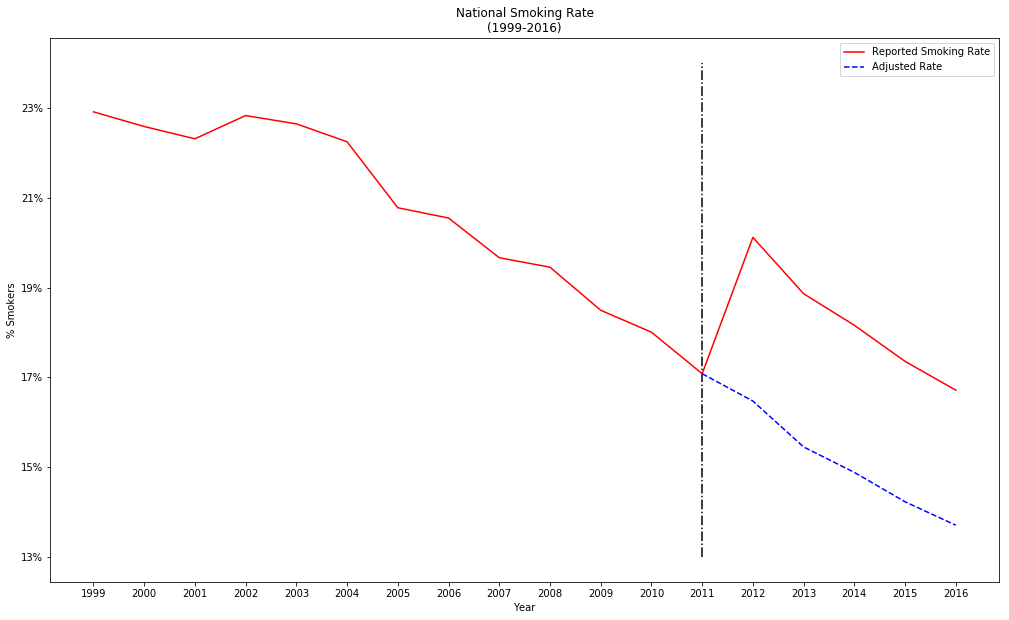

In [47]:
plt.figure(figsize=(17, 10))

plt.plot(mean_smoking_df['Smoking_unadj'], c='r', label = 'Reported Smoking Rate')
plt.plot(mean_smoking_df['Smoking'][mean_smoking_df.index >= 2011], c='b', linestyle = '--', label = 'Adjusted Rate')
plt.vlines(2011, .13, .24, linestyles='-.')

plt.xticks(np.arange(1999, 2017))
plt.yticks(np.arange(.13, .24, .02), labels = [f'{i}%' for i in range(13, 24, 2)])
plt.xlabel('Year')
plt.ylabel('% Smokers')
plt.title('National Smoking Rate\n(1999-2016)')
plt.legend()
plt.show()

<a id='diabetes'></a>
#### 4. Diabetes
Deaths to diabetes used as proxy to estimate rates of diabetes. Symptoms related to diabetes might contribute to heart disease deaths.

In [48]:
diabetes_df = df[df['Cause_Name']=='Diabetes'][['Year', 'State', 'Deaths']]
diabetes_df = diabetes_df.rename(columns={'Deaths': 'Diabetes'})
diabetes_df.head()

,Year,State,Diabetes
4,2016,Alabama,1183
14,2016,Alaska,124
24,2016,Arizona,2025
34,2016,Arkansas,920
44,2016,California,9124


In [49]:
add_diab_df = pd.merge(add_smoking_df, diabetes_df, left_on=['Year', 'State'], right_on=['Year', 'State'])
add_diab_df['Diabetes'] = add_diab_df['Diabetes'] / add_diab_df['Population']
add_diab_df.head()

,Year,Cause_Name,State,Deaths,Population,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,...,Population_80_84_years,Population_85+_years,Sq_Miles,Pop_Density,beer,wine,spirits,all_bevs,Smoking,Diabetes
0,2016,Heart disease,Alabama,12832,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.019281,0.017883,50750.0,95.774286,1.09,0.26,0.65,2.01,0.188127,0.000243
1,2015,Heart disease,Alabama,12981,4850858,0.484665,0.012179,0.048409,0.062936,0.063828,...,0.018973,0.017619,50750.0,95.583409,1.11,0.26,0.64,2.01,0.185489,0.000259
2,2014,Heart disease,Alabama,12461,4840037,0.484787,0.012057,0.048594,0.063281,0.064846,...,0.018777,0.017302,50750.0,95.370187,1.13,0.25,0.62,2.00,0.189006,0.000265
3,2013,Heart disease,Alabama,12472,4827660,0.484981,0.011886,0.049125,0.063570,0.065616,...,0.018685,0.016942,50750.0,95.126305,1.14,0.25,0.60,1.99,0.209225,0.000279
4,2012,Heart disease,Alabama,12036,4813946,0.485060,0.012156,0.049996,0.063502,0.066419,...,0.018758,0.016657,50750.0,94.856079,1.16,0.24,0.60,2.00,0.213620,0.000270


<a id='target'></a>
#### 4. Calculate Target Variable (Deaths_per_Capita)

In [50]:
hd_df = add_diab_df
hd_df.head()

,Year,Cause_Name,State,Deaths,Population,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,...,Population_80_84_years,Population_85+_years,Sq_Miles,Pop_Density,beer,wine,spirits,all_bevs,Smoking,Diabetes
0,2016,Heart disease,Alabama,12832,4860545,0.484347,0.012039,0.048362,0.062506,0.063089,...,0.019281,0.017883,50750.0,95.774286,1.09,0.26,0.65,2.01,0.188127,0.000243
1,2015,Heart disease,Alabama,12981,4850858,0.484665,0.012179,0.048409,0.062936,0.063828,...,0.018973,0.017619,50750.0,95.583409,1.11,0.26,0.64,2.01,0.185489,0.000259
2,2014,Heart disease,Alabama,12461,4840037,0.484787,0.012057,0.048594,0.063281,0.064846,...,0.018777,0.017302,50750.0,95.370187,1.13,0.25,0.62,2.00,0.189006,0.000265
3,2013,Heart disease,Alabama,12472,4827660,0.484981,0.011886,0.049125,0.063570,0.065616,...,0.018685,0.016942,50750.0,95.126305,1.14,0.25,0.60,1.99,0.209225,0.000279
4,2012,Heart disease,Alabama,12036,4813946,0.485060,0.012156,0.049996,0.063502,0.066419,...,0.018758,0.016657,50750.0,94.856079,1.16,0.24,0.60,2.00,0.213620,0.000270


In [51]:
hd_df['Deaths_per_Capita'] = hd_df['Deaths'] / hd_df['Population']

# Set index based on state & year
hd_df['State_Year'] = hd_df['State'] + '_' + hd_df['Year'].astype(str)
hd_df = hd_df.set_index(hd_df['State_Year'])

hd_df = hd_df.drop(columns=['Cause_Name', 'Deaths', 'Population', 'Sq_Miles', 'State_Year', 'State', 'Year'])
hd_df.head()

,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Population_80_84_years,Population_85+_years,Pop_Density,beer,wine,spirits,all_bevs,Smoking,Diabetes,Deaths_per_Capita
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,0.484347,0.012039,0.048362,0.062506,0.063089,0.066052,0.069107,0.068337,0.062332,0.061698,...,0.019281,0.017883,95.774286,1.09,0.26,0.65,2.01,0.188127,0.000243,0.002640
Alabama_2015,0.484665,0.012179,0.048409,0.062936,0.063828,0.065925,0.071293,0.066776,0.062877,0.060945,...,0.018973,0.017619,95.583409,1.11,0.26,0.64,2.01,0.185489,0.000259,0.002676
Alabama_2014,0.484787,0.012057,0.048594,0.063281,0.064846,0.065804,0.073148,0.065357,0.063535,0.060410,...,0.018777,0.017302,95.370187,1.13,0.25,0.62,2.00,0.189006,0.000265,0.002575
Alabama_2013,0.484981,0.011886,0.049125,0.063570,0.065616,0.066477,0.073858,0.064491,0.063740,0.060343,...,0.018685,0.016942,95.126305,1.14,0.25,0.60,1.99,0.209225,0.000279,0.002583
Alabama_2012,0.485060,0.012156,0.049996,0.063502,0.066419,0.067235,0.073380,0.064310,0.063665,0.060729,...,0.018758,0.016657,94.856079,1.16,0.24,0.60,2.00,0.213620,0.000270,0.002500


<a id='transform'></a>

### Explore Data

In [52]:
hd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, Alabama_2016 to Wyoming_1999
Data columns (total 28 columns):
Population_Male            918 non-null float64
Population_<_1_year        918 non-null float64
Population_1_4_years       918 non-null float64
Population_5_9_years       918 non-null float64
Population_10_14_years     918 non-null float64
Population_15_19_years     918 non-null float64
Population_20_24_years     918 non-null float64
Population_25_29_years     918 non-null float64
Population_30_34_years     918 non-null float64
Population_35_39_years     918 non-null float64
Population_40_44_years     918 non-null float64
Population_45_49_years     918 non-null float64
Population_50_54_years     918 non-null float64
Population_55_59_years     918 non-null float64
Population_60_64_years_    918 non-null float64
Population_65_69_years     918 non-null float64
Population_70_74_years     918 non-null float64
Population_75_79_years     918 non-null float64
Population_80_84

In [53]:
hd_df.describe()

,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Population_80_84_years,Population_85+_years,Pop_Density,beer,wine,spirits,all_bevs,Smoking,Diabetes,Deaths_per_Capita
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,...,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,0.492744,0.013093,0.052031,0.066006,0.068364,0.070826,0.071147,0.066853,0.066474,0.067752,...,0.018588,0.017429,360.544804,1.233475,0.375556,0.798475,2.407505,0.197257,0.000250,0.002135
std,0.008036,0.001638,0.005694,0.006496,0.006572,0.005593,0.006883,0.008315,0.006813,0.007635,...,0.003213,0.004132,1225.170591,0.217358,0.195609,0.277674,0.531311,0.044162,0.000056,0.000481
min,0.470729,0.009192,0.038622,0.042565,0.038807,0.053589,0.054894,0.049994,0.053501,0.053990,...,0.005645,0.003939,1.094872,0.630000,0.100000,0.360000,1.250000,0.066968,0.000107,0.000883
25%,0.487136,0.012157,0.048655,0.062670,0.064776,0.066984,0.067824,0.062663,0.062372,0.061818,...,0.016917,0.014708,43.020646,1.090000,0.220000,0.630000,2.080000,0.167110,0.000214,0.001812
50%,0.491545,0.013024,0.051847,0.066178,0.068489,0.070818,0.070614,0.065976,0.065398,0.066532,...,0.018758,0.017298,99.558002,1.220000,0.330000,0.740000,2.330000,0.201000,0.000248,0.002092
75%,0.497149,0.013939,0.055118,0.069417,0.072434,0.073652,0.073300,0.070254,0.069804,0.073273,...,0.020453,0.020400,223.290201,1.380000,0.500000,0.890000,2.590000,0.228000,0.000283,0.002472
max,0.523698,0.020272,0.077162,0.090231,0.090548,0.099466,0.104689,0.123434,0.113322,0.092383,...,0.026185,0.027776,10013.696225,1.900000,1.190000,2.000000,4.770000,0.326000,0.000470,0.003765


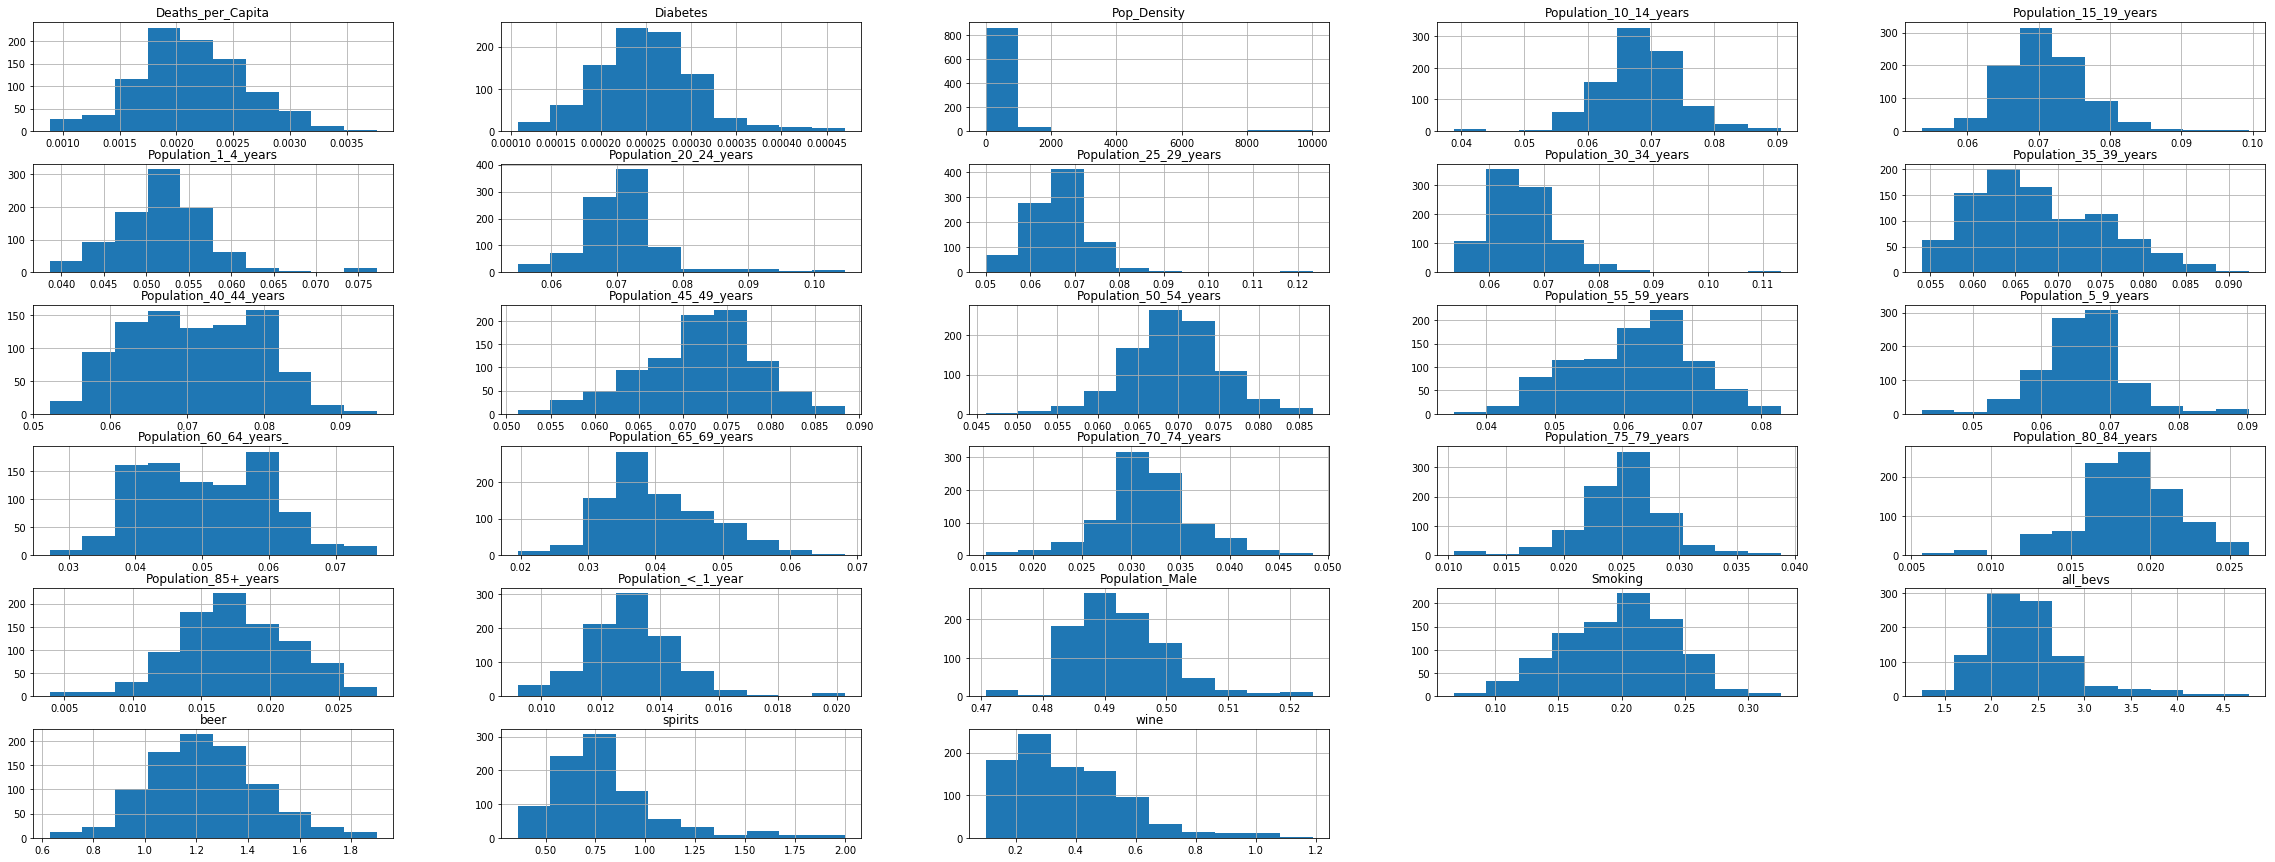

In [54]:
# View feature distributions
hd_df.hist(figsize = (40, 15))
plt.show()

Slight skewness throughout. Perform log normalization and re-check distributions.

<function matplotlib.pyplot.show(*args, **kw)>

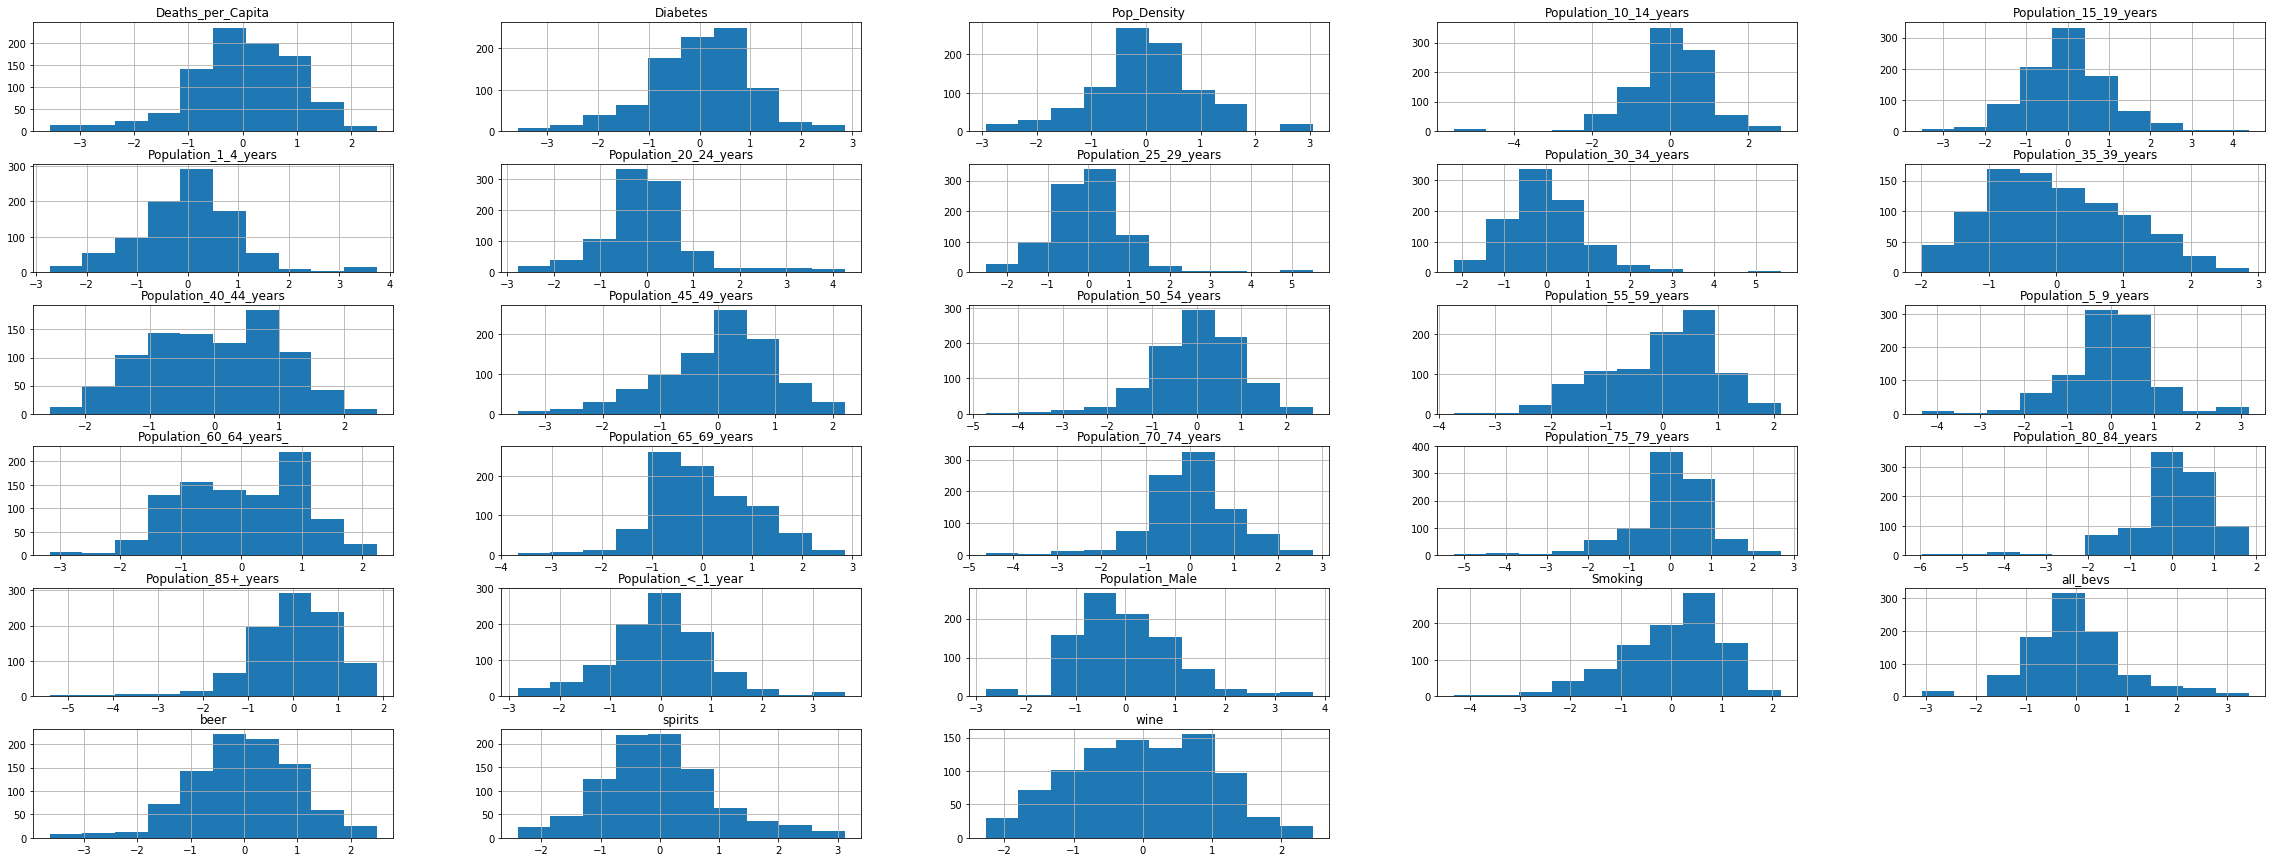

In [55]:
from sklearn import preprocessing

log_df = pd.DataFrame()
for col in hd_df.columns:
    log_df[col] = np.log(hd_df[col])
#     hd_df[col] = (hd_df[col] - hd_df[col].min())/(hd_df[col].max() - hd_df[col].min())
#     hd_df = hd_df.rename(columns = {col:f'log_norm_{col}'})  

transformed_df = pd.DataFrame(preprocessing.scale(log_df), columns = log_df.columns).set_index(hd_df.index)

transformed_df.hist(figsize=(40, 15))
plt.show

In [56]:
def coll_check(data, size=(11,9)):
    # Create a covariance matrix
    corr = data.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, vmin=-.4, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
#     plt.savefig('cov_matrix_' + str(len(data.columns)) + '_inputs.png', dpi=100)

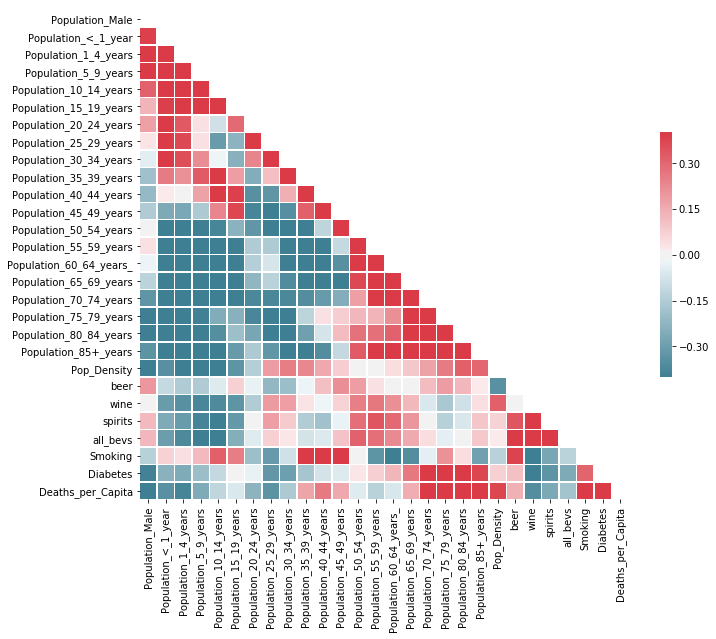

In [57]:
coll_check(transformed_df)

<a id='linreg'></a>
### Regression Analysis

In [58]:
# Explore combinations of 8 predictor variables for regression analysis
from itertools import combinations as comb

combs = list(comb(transformed_df.columns[:-4], 5))
predictors = transformed_df.columns[:-4]

len(combs)

42504

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(transformed_df.drop(columns=['Deaths_per_Capita']), 
                                                    transformed_df['Deaths_per_Capita'],
                                                    test_size = .25, 
                                                    random_state = 123)

best_model = {'Features': [], 'RMSE': 10**1000000}
i = 1
t0 = time.time()
t2 = time.time()
for c in combs:


    linreg = LinearRegression()
    linreg.fit(X_train[list(c)], y_train)
    y_preds = linreg.predict(X_test[list(c)])
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    if rmse < best_model['RMSE']:
        best_model['Features'] = list(c)
        best_model['RMSE'] = rmse
    if i % np.round((len(combs) * .1), 0) == 0:
        t1 = time.time()
        print(f'{100 * i/len(combs):.2f}% Complete')
        print(f'Total Time: {t1 - t0:.2f}s')
        print(f'Lap Time: {t1 - t2:.2f}s \n')
        t2 = time.time()
        
    i += 1
    
best_model

10.00% Complete
Total Time: 12.57s
Lap Time: 12.57s 

20.00% Complete
Total Time: 23.50s
Lap Time: 10.93s 

30.00% Complete
Total Time: 35.19s
Lap Time: 11.70s 

40.00% Complete
Total Time: 47.81s
Lap Time: 12.62s 

50.00% Complete
Total Time: 61.03s
Lap Time: 13.22s 

59.99% Complete
Total Time: 73.65s
Lap Time: 12.61s 

69.99% Complete
Total Time: 86.42s
Lap Time: 12.78s 

79.99% Complete
Total Time: 97.51s
Lap Time: 11.08s 

89.99% Complete
Total Time: 108.80s
Lap Time: 11.29s 

99.99% Complete
Total Time: 121.62s
Lap Time: 12.82s 



{'Features': ['Population_Male',
  'Population_60_64_years_',
  'Population_75_79_years',
  'beer',
  'wine'],
 'RMSE': 0.44640717472525354}

In [60]:
transformed_df.columns

Index(['Population_Male', 'Population_<_1_year', 'Population_1_4_years',
       'Population_5_9_years', 'Population_10_14_years',
       'Population_15_19_years', 'Population_20_24_years',
       'Population_25_29_years', 'Population_30_34_years',
       'Population_35_39_years', 'Population_40_44_years',
       'Population_45_49_years', 'Population_50_54_years',
       'Population_55_59_years', 'Population_60_64_years_',
       'Population_65_69_years', 'Population_70_74_years',
       'Population_75_79_years', 'Population_80_84_years',
       'Population_85+_years', 'Pop_Density', 'beer', 'wine', 'spirits',
       'all_bevs', 'Smoking', 'Diabetes', 'Deaths_per_Capita'],
      dtype='object')

In [61]:
import statsmodels.formula.api as smf

predictors = ['Population_Male', 'Population_75_79_years', 'wine', 'Smoking']

f = 'Deaths_per_Capita~'
for predictor in predictors:
    f += '+' + predictor
model = smf.ols(formula=f, data=transformed_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Deaths_per_Capita   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1153.
Date:                Tue, 21 May 2019   Prob (F-statistic):               0.00
Time:                        13:34:04   Log-Likelihood:                -476.10
No. Observations:                 918   AIC:                             962.2
Df Residuals:                     913   BIC:                             986.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               2.86

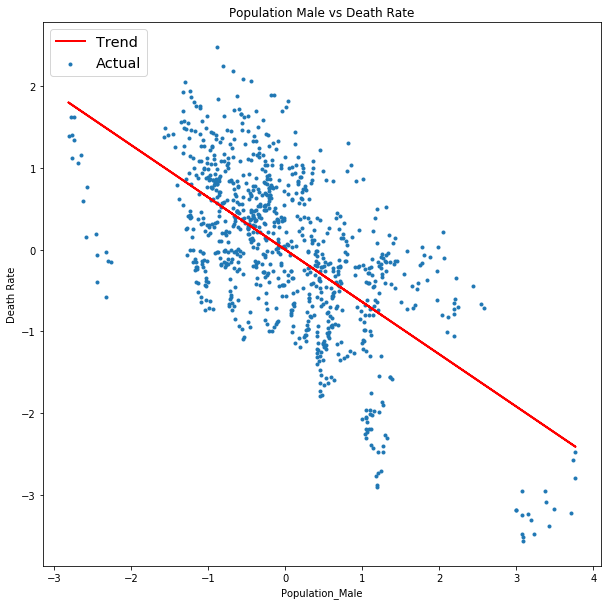

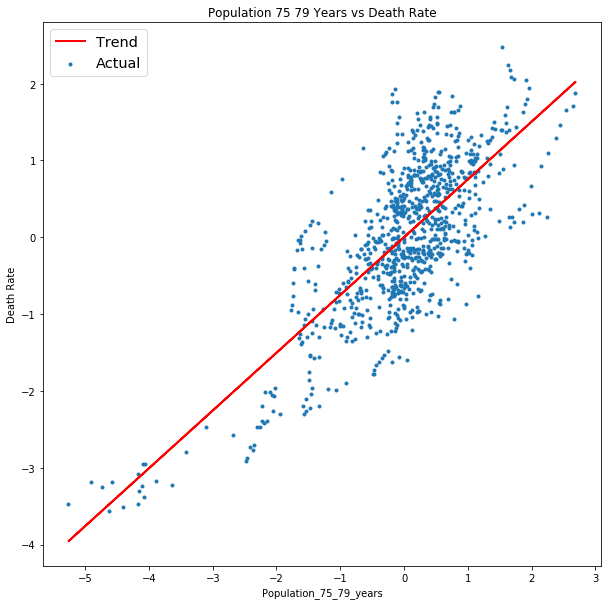

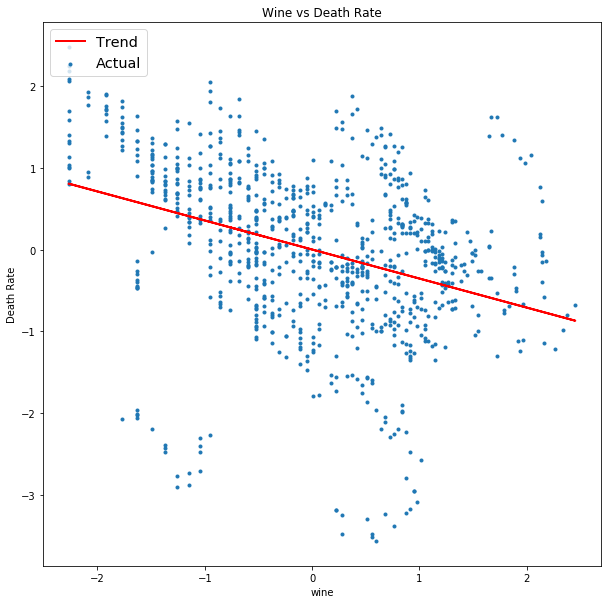

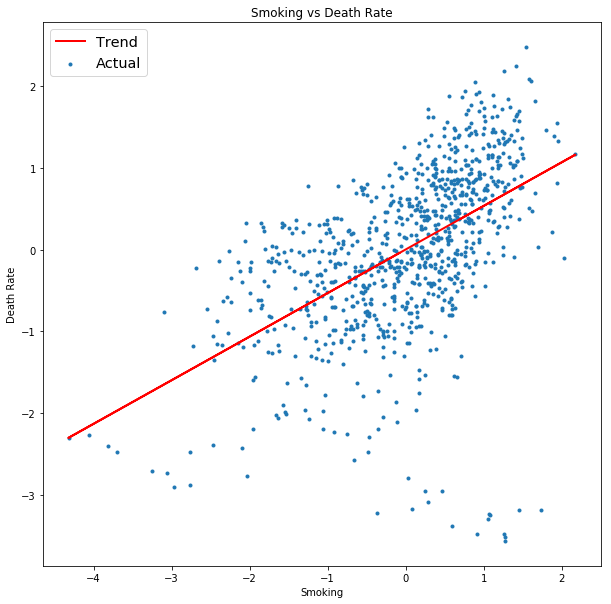

,Variable,R Squared,Intercept,Slope,P Value
0,Population_Male,0.409124,2.862294e-17,-0.639628,9.108390e-107
1,Population_75_79_years,0.565296,2.862294e-17,0.751862,6.873118e-168
2,wine,0.125982,2.862294e-17,-0.354940,1.212843e-28
3,Smoking,0.283746,2.862294e-17,0.532678,2.060946e-68


In [62]:
results = [['Variable', 'R Squared', 'Intercept', 'Slope', 'P Value']]

for predictor in predictors:
    f = 'Deaths_per_Capita~' + predictor
    model = smf.ols(formula=f, data=transformed_df).fit()
    results.append([predictor, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
    y_pred = model.predict()
    plt.figure(figsize=(10, 10))
    plt.title(predictor.replace('_', ' ').title() + ' vs Death Rate')
    plt.xlabel(predictor)
    plt.ylabel('Death Rate')
    plt.scatter(transformed_df[predictor], transformed_df['Deaths_per_Capita'], marker='.', label='Actual')
    plt.plot(transformed_df[predictor], y_pred, color='r', lw=2, label='Trend')
    plt.legend(loc=2, fontsize='x-large')
    plt.show()
#     plt.savefig('scatter_log_' + f + '.png', dpi=100)

result_df = pd.DataFrame(results[1:],columns=results[0])
result_df

<a id='linreg_obs'></a>
### Observations
Demographic data clearly has the largest effect on deaths to heart disease, particularly with regard to ages 70+ and gender. Smoking also has a clear impact, though it was surprising to see that alcohol consumption seems to have a negative relationship. However, negative collinearity was observed between smoking and wine consumption, making these variables difficult to disentangle.

<a id='classify'></a>
## Create Classification Targets
Base risk levels on previous 15 years of data:
* **High Risk:** Top 33% of death rates
* **Medium Risk:** Middle 33% of death rates
* **Low Risk:** Lowest 33% of death rates

In [63]:
transformed_df.head()

,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Population_80_84_years,Population_85+_years,Pop_Density,beer,wine,spirits,all_bevs,Smoking,Diabetes,Deaths_per_Capita
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.624540,-0.629633,-0.498151,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,...,0.274443,0.216467,0.002169,-0.599453,-0.447217,-0.498100,-0.771982,-0.080491,-0.012987,0.996612
Alabama_2015,-1.011486,-0.529570,-0.620650,-0.429347,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,...,0.192684,0.161113,0.000858,-0.498350,-0.447217,-0.548017,-0.771982,-0.138447,0.253152,1.052941
Alabama_2014,-0.995961,-0.612363,-0.584884,-0.374447,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,...,0.139909,0.093588,-0.000609,-0.399053,-0.521983,-0.650235,-0.796258,-0.061352,0.352235,0.892148
Alabama_2013,-0.971242,-0.728990,-0.483217,-0.328599,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,...,0.115174,0.015390,-0.002291,-0.350062,-0.521983,-0.755805,-0.820656,0.355870,0.588770,0.906471
Alabama_2012,-0.961257,-0.545397,-0.318997,-0.339315,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,...,0.135015,-0.047637,-0.004159,-0.253356,-0.599801,-0.755805,-0.796258,0.441220,0.439944,0.770267


In [64]:
hd_classify_df = transformed_df
hd_classify_df['Year'] = hd_classify_df.index.astype(str).str[-4:].astype(int)
hd_classify_df['State'] = hd_classify_df.index.astype(str).str[:-5]
hd_classify_df['Risk_Level'] = pd.qcut(hd_classify_df['Deaths_per_Capita'], 3, labels=[1, 2, 3]).astype(int)
hd_classify_df = hd_classify_df.drop(columns=['Deaths_per_Capita'])
hd_classify_df.head(5)

,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Pop_Density,beer,wine,spirits,all_bevs,Smoking,Diabetes,Year,State,Risk_Level
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.624540,-0.629633,-0.498151,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,...,0.002169,-0.599453,-0.447217,-0.498100,-0.771982,-0.080491,-0.012987,2016,Alabama,3
Alabama_2015,-1.011486,-0.529570,-0.620650,-0.429347,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,...,0.000858,-0.498350,-0.447217,-0.548017,-0.771982,-0.138447,0.253152,2015,Alabama,3
Alabama_2014,-0.995961,-0.612363,-0.584884,-0.374447,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,...,-0.000609,-0.399053,-0.521983,-0.650235,-0.796258,-0.061352,0.352235,2014,Alabama,3
Alabama_2013,-0.971242,-0.728990,-0.483217,-0.328599,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,...,-0.002291,-0.350062,-0.521983,-0.755805,-0.820656,0.355870,0.588770,2013,Alabama,3
Alabama_2012,-0.961257,-0.545397,-0.318997,-0.339315,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,...,-0.004159,-0.253356,-0.599801,-0.755805,-0.796258,0.441220,0.439944,2012,Alabama,3


In [65]:
hd_classify_df[hd_classify_df['Year']==2016][['State', 'Risk_Level']].set_index(['State']).to_csv('2016_results.csv')

In [66]:
hd_classify_df.describe()

,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Population_85+_years,Pop_Density,beer,wine,spirits,all_bevs,Smoking,Diabetes,Year,Risk_Level
count,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,...,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,918.000000,918.000000
mean,5.226272e-15,-1.598697e-15,4.567788e-15,2.936528e-15,-5.236673e-16,-2.151269e-15,-8.708841e-16,2.372830e-15,1.273733e-15,7.592813e-15,...,-4.218364e-16,-7.667553e-17,-3.144423e-17,1.487554e-16,2.682434e-16,2.537005e-16,-9.161154e-16,-2.757900e-15,2007.500000,2.000000
std,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,...,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,5.190956,0.816942
min,-2.810795e+00,-2.829362e+00,-2.732704e+00,-4.358562e+00,-5.557939e+00,-3.529691e+00,-2.778398e+00,-2.528145e+00,-2.208127e+00,-1.998725e+00,...,-5.413622e+00,-2.935043e+00,-3.647780e+00,-2.268694e+00,-2.400462e+00,-3.083963e+00,-4.320728e+00,-3.584386e+00,1999.000000,1.000000
25%,-6.977848e-01,-5.446094e-01,-5.732945e-01,-4.718394e-01,-4.852468e-01,-6.746264e-01,-4.738053e-01,-5.168749e-01,-6.125476e-01,-7.734949e-01,...,-5.109014e-01,-5.235536e-01,-5.994526e-01,-7.656696e-01,-5.987204e-01,-6.053544e-01,-5.668016e-01,-5.690472e-01,2003.000000,1.000000
50%,-1.421054e-01,1.832297e-02,2.096768e-02,7.538995e-02,6.653786e-02,3.780706e-02,-3.456223e-02,-5.811694e-02,-1.198818e-01,-1.085366e-01,...,9.278676e-02,2.762095e-02,2.706406e-02,7.262391e-03,-8.058823e-02,-5.290045e-02,1.912323e-01,6.380597e-02,2007.500000,2.000000
75%,5.569931e-01,5.735314e-01,5.931760e-01,5.554060e-01,6.210985e-01,5.398200e-01,3.721007e-01,5.013090e-01,5.582369e-01,7.647048e-01,...,7.066704e-01,5.582144e-01,7.122964e-01,7.993532e-01,5.136583e-01,4.620220e-01,7.086542e-01,6.391921e-01,2012.000000,3.000000
max,3.765588e+00,3.633933e+00,3.739173e+00,3.190229e+00,2.831098e+00,4.384961e+00,4.255778e+00,5.519756e+00,5.597724e+00,2.861815e+00,...,1.855157e+00,3.056544e+00,2.490373e+00,2.452294e+00,3.120511e+00,3.434499e+00,2.176474e+00,2.857276e+00,2016.000000,3.000000


<a id='featlag'></a>
### Create 1 - 5 Year Lags for Features
To base estimates of risk levels on data from the same year is not particularly helpful. For example, data for 2015 does not become available until 2016, as will death counts. While this data is useful for descriptive measures, it does not help in making predictions, so the objective is to make predictions for 2016 data based on 2014 data and prior. Lags will be created for 1 - 5 years, though lags for years 3 - 5 are all that will be considered for model training and testing.

In [67]:
lag_df = hd_classify_df[hd_classify_df['Year']>2003]
lag_df[lag_df['State'] == 'New York']

,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Pop_Density,beer,wine,spirits,all_bevs,Smoking,Diabetes,Year,State,Risk_Level
State_Year,,,,,,,,,,,,,,,,,,,,,
New York_2016,-0.919288,-0.696220,-0.849602,-1.361222,-1.607394,-1.612954,-0.153143,1.274673,0.668162,-0.444013,...,0.973304,-1.603054,0.910430,0.088904,-0.288294,-1.822010,-0.791516,2016,New York,2
New York_2015,-0.952454,-0.534533,-0.774095,-1.366759,-1.499181,-1.487802,0.062103,1.192576,0.571097,-0.555472,...,0.972743,-1.664497,0.799353,0.047360,-0.376795,-2.043967,-0.780247,2015,New York,2
New York_2014,-0.973160,-0.597827,-0.736934,-1.310876,-1.365138,-1.312458,0.293894,1.078204,0.526377,-0.667404,...,0.971224,-1.664497,0.910430,0.005273,-0.332343,-1.460313,-0.749753,2014,New York,2
New York_2013,-0.986310,-0.483525,-0.782672,-1.178406,-1.266299,-1.026928,0.376678,0.958089,0.454388,-0.737465,...,0.969192,-1.482169,0.837103,0.047360,-0.310269,-1.560445,-0.704227,2013,New York,2
New York_2012,-1.014355,-0.447402,-0.781678,-1.104193,-1.152122,-0.723491,0.416794,0.850139,0.314836,-0.760024,...,0.966283,-1.603054,0.837103,-0.037371,-0.399174,-1.105175,-0.775265,2012,New York,2
New York_2011,-1.060145,-0.307083,-0.800766,-1.040887,-1.010034,-0.420499,0.405304,0.760602,0.176800,-0.686582,...,0.962960,-1.726625,0.799353,-0.168802,-0.535653,-0.875625,-0.777192,2011,New York,2
New York_2010,-1.097710,-0.542247,-0.775333,-0.930652,-0.874163,-0.098233,0.315600,0.647059,0.013449,-0.419779,...,0.958870,-1.726625,0.721535,-0.213832,-0.582009,-0.261768,-1.145533,2010,New York,2
New York_2009,-1.123717,-0.466127,-0.764496,-0.880819,-0.711203,0.163376,0.166721,0.610340,-0.119270,-0.105637,...,0.955540,-1.542283,0.681401,-0.259501,-0.605354,-0.544997,-1.027594,2009,New York,3
New York_2008,-1.130821,-0.256430,-0.749815,-0.890002,-0.515160,0.316944,0.019668,0.553036,-0.249631,0.191376,...,0.952313,-1.482169,0.681401,-0.352830,-0.605354,-0.061475,-1.146529,2008,New York,3


In [68]:
lag_tags = {}
for i in range(5):
    lag_tags[f'lag_{i + 1}'] = hd_classify_df[(hd_classify_df['Year'] >= 2003 - i) & (hd_classify_df['Year'] < 2016 - i)]
lag_tags.keys()

dict_keys(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'])

In [69]:
i = 1
for k in lag_tags.keys():
    rename = {}
    for col in lag_tags[k].columns:
        rename[col] = f'{col}_lag_{i}'
    lag_tags[k] = lag_tags[k].rename(columns=rename)
    i+=1
    
lag_tags['lag_1'].shape, lag_df.shape

((663, 30), (663, 30))

In [70]:
for k in lag_tags.keys():
    for col in lag_tags[k].columns[:-3]:
        lag_df[col] = list(lag_tags[k][col])
        
lag_df.head(13)

,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Population_75_79_years_lag_5,Population_80_84_years_lag_5,Population_85+_years_lag_5,Pop_Density_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,all_bevs_lag_5,Smoking_lag_5,Diabetes_lag_5
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.624540,-0.629633,-0.498151,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,...,0.263184,0.135407,-0.143233,-0.006250,-0.253356,-0.599801,-0.809918,-0.845177,0.543322,0.379440
Alabama_2015,-1.011486,-0.529570,-0.620650,-0.429347,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,...,0.198928,0.103197,-0.213527,-0.008042,-0.205626,-0.680932,-0.864955,-0.845177,0.654280,0.472395
Alabama_2014,-0.995961,-0.612363,-0.584884,-0.374447,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,...,0.162211,0.079633,-0.286688,-0.011847,-0.111378,-0.765670,-0.920950,-0.845177,0.580642,0.351297
Alabama_2013,-0.971242,-0.728990,-0.483217,-0.328599,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,...,0.222108,0.120536,-0.343127,-0.017355,0.027064,-0.765670,-0.920950,-0.771982,0.654280,0.806606
Alabama_2012,-0.961257,-0.545397,-0.318997,-0.339315,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,...,0.274017,0.085952,-0.394096,-0.023702,0.072456,-0.765670,-1.035948,-0.796258,0.780051,0.612936
Alabama_2011,-0.949256,-0.431463,-0.174352,-0.342204,-0.149929,-0.343002,0.212893,-0.245984,-0.443047,-0.782127,...,0.347884,0.067667,-0.446071,-0.029897,-0.018701,-0.854350,-1.095025,-0.919491,1.053832,1.095506
Alabama_2010,-0.913513,-0.391786,-0.097636,-0.229185,-0.166654,0.110520,-0.039701,-0.188210,-0.579360,-0.450187,...,0.368832,0.077824,-0.501016,-0.038349,-0.158302,-0.947358,-1.155206,-1.020373,1.070352,1.078994
Alabama_2009,-0.910658,-0.004613,-0.095946,-0.150764,-0.142015,0.399590,-0.160517,-0.106746,-0.732784,-0.216639,...,0.390670,0.093072,-0.574748,-0.043990,-0.111378,-0.947358,-1.216534,-1.020373,1.135775,1.176978
Alabama_2008,-0.979136,0.327165,-0.117594,-0.105159,-0.045621,0.468782,-0.180140,-0.051921,-0.863394,-0.109799,...,0.448252,0.051319,-0.548674,-0.047951,-0.111378,-1.045138,-1.216534,-1.045924,0.987079,1.096709


In [71]:
lag_df['risk_level'] = lag_df['Risk_Level']
lag_df = lag_df.drop(columns=['Risk_Level', 'Year', 'State'])
lag_df = lag_df.rename(columns={'risk_level': 'Risk_Level'})

# Save final dataframe to csv
lag_df.to_csv('final_dataset.csv')

In [72]:
lag_df.head()

,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Population_80_84_years_lag_5,Population_85+_years_lag_5,Pop_Density_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,all_bevs_lag_5,Smoking_lag_5,Diabetes_lag_5,Risk_Level
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.624540,-0.629633,-0.498151,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,...,0.135407,-0.143233,-0.006250,-0.253356,-0.599801,-0.809918,-0.845177,0.543322,0.379440,3
Alabama_2015,-1.011486,-0.529570,-0.620650,-0.429347,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,...,0.103197,-0.213527,-0.008042,-0.205626,-0.680932,-0.864955,-0.845177,0.654280,0.472395,3
Alabama_2014,-0.995961,-0.612363,-0.584884,-0.374447,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,...,0.079633,-0.286688,-0.011847,-0.111378,-0.765670,-0.920950,-0.845177,0.580642,0.351297,3
Alabama_2013,-0.971242,-0.728990,-0.483217,-0.328599,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,...,0.120536,-0.343127,-0.017355,0.027064,-0.765670,-0.920950,-0.771982,0.654280,0.806606,3
Alabama_2012,-0.961257,-0.545397,-0.318997,-0.339315,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,...,0.085952,-0.394096,-0.023702,0.072456,-0.765670,-1.035948,-0.796258,0.780051,0.612936,3


<a id='mlm'></a>
## Machine Learning Models

In [73]:
lag_df = pd.read_csv('final_dataset.csv', index_col=0)
lag_df.head(14)

,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Population_80_84_years_lag_5,Population_85+_years_lag_5,Pop_Density_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,all_bevs_lag_5,Smoking_lag_5,Diabetes_lag_5,Risk_Level
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.624540,-0.629633,-0.498151,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,...,0.135407,-0.143233,-0.006250,-0.253356,-0.599801,-0.809918,-0.845177,0.543322,0.379440,3
Alabama_2015,-1.011486,-0.529570,-0.620650,-0.429347,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,...,0.103197,-0.213527,-0.008042,-0.205626,-0.680932,-0.864955,-0.845177,0.654280,0.472395,3
Alabama_2014,-0.995961,-0.612363,-0.584884,-0.374447,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,...,0.079633,-0.286688,-0.011847,-0.111378,-0.765670,-0.920950,-0.845177,0.580642,0.351297,3
Alabama_2013,-0.971242,-0.728990,-0.483217,-0.328599,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,...,0.120536,-0.343127,-0.017355,0.027064,-0.765670,-0.920950,-0.771982,0.654280,0.806606,3
Alabama_2012,-0.961257,-0.545397,-0.318997,-0.339315,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,...,0.085952,-0.394096,-0.023702,0.072456,-0.765670,-1.035948,-0.796258,0.780051,0.612936,3
Alabama_2011,-0.949256,-0.431463,-0.174352,-0.342204,-0.149929,-0.343002,0.212893,-0.245984,-0.443047,-0.782127,...,0.067667,-0.446071,-0.029897,-0.018701,-0.854350,-1.095025,-0.919491,1.053832,1.095506,3
Alabama_2010,-0.913513,-0.391786,-0.097636,-0.229185,-0.166654,0.110520,-0.039701,-0.188210,-0.579360,-0.450187,...,0.077824,-0.501016,-0.038349,-0.158302,-0.947358,-1.155206,-1.020373,1.070352,1.078994,3
Alabama_2009,-0.910658,-0.004613,-0.095946,-0.150764,-0.142015,0.399590,-0.160517,-0.106746,-0.732784,-0.216639,...,0.093072,-0.574748,-0.043990,-0.111378,-0.947358,-1.216534,-1.020373,1.135775,1.176978,3
Alabama_2008,-0.979136,0.327165,-0.117594,-0.105159,-0.045621,0.468782,-0.180140,-0.051921,-0.863394,-0.109799,...,0.051319,-0.548674,-0.047951,-0.111378,-1.045138,-1.216534,-1.045924,0.987079,1.096709,3


<a id='featheat'></a>
### Split Data Into Target & Feature Sets
**Features** set to include only 3 - 5 year time lags for predictions. Results for prior year are generally available 6 months into the next year. As such, these columns will not be of practical use for making predictions and are therefore not to be included in the feature set.

In [74]:
features = lag_df.drop(columns=lag_df.columns[:81])
features = features.drop(columns=['Risk_Level'])
target = lag_df['Risk_Level']

In [75]:
features.columns

Index(['Population_Male_lag_3', 'Population_<_1_year_lag_3',
       'Population_1_4_years_lag_3', 'Population_5_9_years_lag_3',
       'Population_10_14_years_lag_3', 'Population_15_19_years_lag_3',
       'Population_20_24_years_lag_3', 'Population_25_29_years_lag_3',
       'Population_30_34_years_lag_3', 'Population_35_39_years_lag_3',
       'Population_40_44_years_lag_3', 'Population_45_49_years_lag_3',
       'Population_50_54_years_lag_3', 'Population_55_59_years_lag_3',
       'Population_60_64_years__lag_3', 'Population_65_69_years_lag_3',
       'Population_70_74_years_lag_3', 'Population_75_79_years_lag_3',
       'Population_80_84_years_lag_3', 'Population_85+_years_lag_3',
       'Pop_Density_lag_3', 'beer_lag_3', 'wine_lag_3', 'spirits_lag_3',
       'all_bevs_lag_3', 'Smoking_lag_3', 'Diabetes_lag_3',
       'Population_Male_lag_4', 'Population_<_1_year_lag_4',
       'Population_1_4_years_lag_4', 'Population_5_9_years_lag_4',
       'Population_10_14_years_lag_4', 'Popu

#### Inspect Feature Correlation Heat Map

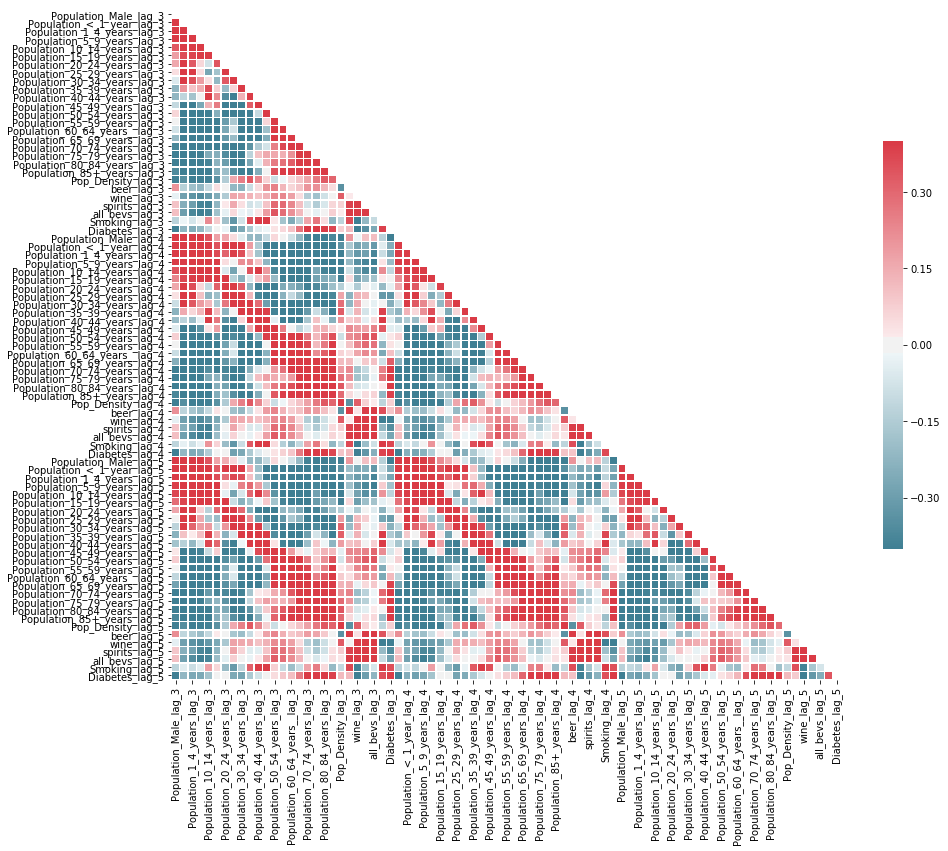

In [76]:
coll_check(features, size=(15, 15))

<a id='methodology'></a>
## Model Methodology
A number of classification models will be built in an effort to identify those which yield the greatest predictive power. Data have already undergone scaling and logarithmic transformations.

A primary component analysis will first be performed to reduce dimentionality, while still maintaining 99% of variance. A 20% of the data will be withheld from the model for testing purposes, and models will be trained on the remaining data using 5 crossfold validations. Each model will be optimized to maximize the **Accuracy Score.** The follow classification models will be utilized in conjunction with Gridsearch:

* **Decision Tree Classification**
* **Logistic Regression**
* **Support Vector Machine**
* **Random Forest Classification**
* **Adaboost**
* **XGBoost**

<a id='methodology'></a>
### Identify Top Features with PCA

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2, random_state=123)

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.99, random_state=123)
feat_pca = pca.fit_transform(features)
n_feat = feat_pca.shape[1]

print(f'Number of Features: {n_feat}\n')
print(f'Cumulative Sum Variance:\n{np.cumsum(pca.explained_variance_ratio_)}')

Number of Features: 19

Cumulative Sum Variance:
[0.33122843 0.49202595 0.62407142 0.74183698 0.80902238 0.85685049
 0.90199004 0.92306302 0.93735962 0.9502196  0.96022557 0.969027
 0.97462333 0.97905677 0.98222174 0.98513882 0.9872274  0.98877729
 0.99021595]


<a id='tree'></a>
### Decision Tree Pipline with PCA & Gridsearch

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

tree_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                      ('clf', DecisionTreeClassifier(random_state=123))])

tree_grid = [{'clf__criterion': ['gini', 'entropy'],
              'clf__max_depth': list(range(1, 11, 2)), 
              'clf__min_samples_split': [i/100 for i in range(5, 96, 10)], 
              'clf__min_samples_leaf': list(range(1, 11, 2))}]

tree_gridsearch = GridSearchCV(estimator = tree_pipe, 
                              param_grid = tree_grid, 
                              scoring = 'accuracy', 
                              cv=5, verbose = 1, return_train_score = True)

tree_gridsearch.fit(X_train, y_train)
print(f'Best Decision Tree Pipeline Score: {tree_gridsearch.best_score_}')
print(f'Parameters: {tree_gridsearch.best_params_}')

results = {'Pipeline': ['Decision Tree'], 
           'Top Score': [tree_gridsearch.best_score_], 
           'Parameters': [tree_gridsearch.best_params_]}

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Decision Tree Pipeline Score: 0.7113207547169811
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 7, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 0.05}


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   24.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<a id='logreg'></a>
### Logistic Regression Pipline with PCA & Gridsearch

In [80]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                        ('logreg', LogisticRegression(random_state=123))])

logreg_grid = [{'logreg__C': [.001, 0.01, 0.1, 1, 10, 100, 1000], 
                'logreg__penalty': ['l1', 'l2']}]

logreg_gridsearch = GridSearchCV(estimator = logreg_pipe, 
                                 param_grid = logreg_grid, 
                                 scoring = 'accuracy', 
                                 cv = 5, verbose = 1, return_train_score = True)

logreg_gridsearch.fit(X_train, y_train)

print(f'Best Logistic Regression Pipeline Score: {logreg_gridsearch.best_score_}')
print(f'Parameters: {logreg_gridsearch.best_params_}')

results['Pipeline'].append('Logistic Regression')
results['Top Score'].append(logreg_gridsearch.best_score_)
results['Parameters'].append(logreg_gridsearch.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Logistic Regression Pipeline Score: 0.8056603773584906
Parameters: {'logreg__C': 100, 'logreg__penalty': 'l1'}


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.3s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<a id='svm'></a>
### Support Vector Machine Pipeline with PCA & Gridsearch

In [81]:
from sklearn.svm import SVC

svm_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('svm', SVC(random_state=123))])

svm_grid = [{'svm__kernel': ['linear'],
             'svm__C': [.1, 1, 10], 
             'svm__degree': list(range(1, 11, 2))}, 
            
            {'svm__kernel': ['rbf'],
             'svm__C': [.1, 1, 10],
             'svm__degree': list(range(1, 11, 2)),
             'svm__gamma': [0.001, .01, 'auto']}
           ]

svm_gridsearch = GridSearchCV(estimator = svm_pipe, 
                              param_grid = svm_grid, 
                              scoring = 'accuracy', 
                              cv = 5, verbose = 1, return_train_score = True)

svm_gridsearch.fit(X_train, y_train)

print(f'Best SVM Pipeline Score: {svm_gridsearch.best_score_}')
print(f'Parameters: {svm_gridsearch.best_params_}')

results['Pipeline'].append('Support Vector Machine')
results['Top Score'].append(svm_gridsearch.best_score_)
results['Parameters'].append(svm_gridsearch.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best SVM Pipeline Score: 0.9018867924528302
Parameters: {'svm__C': 10, 'svm__degree': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    9.4s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<a id='rf'></a>
### Random Forest with PCA & Gridsearch

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                    ('rf', RandomForestClassifier(random_state=123))])

rf_grid = [{'rf__criterion': ['gini', 'entropy'],
            'rf__max_depth': list(range(1, 11, 2)), 
            'rf__min_samples_split': [i/100 for i in range(5, 96, 10)], 
            'rf__min_samples_leaf': list(range(1, 11, 2))}]

rf_gridsearch = GridSearchCV(estimator = rf_pipe, 
                             param_grid = rf_grid, 
                             scoring = 'accuracy', 
                             cv = 5, verbose = 1, return_train_score = True)

rf_gridsearch.fit(X_train, y_train)

print(f'Best Random Forest Pipeline Score: {rf_gridsearch.best_score_}')
print(f'Parameters: {rf_gridsearch.best_params_}')

results['Pipeline'].append('Random Forest')
results['Top Score'].append(rf_gridsearch.best_score_)
results['Parameters'].append(rf_gridsearch.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Random Forest Pipeline Score: 0.7849056603773585
Parameters: {'rf__criterion': 'gini', 'rf__max_depth': 9, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 0.05}


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   50.0s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<a id='ada'></a>
### Adaboost with PCA & Gridsearch

In [83]:
from sklearn.ensemble import AdaBoostClassifier

ada_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('ada', AdaBoostClassifier(random_state=123))])


ada_grid = [{'ada__learning_rate': [i/100 for i in range(1, 100)]}]

ada_gridsearch = GridSearchCV(estimator = ada_pipe, 
                              param_grid = ada_grid, 
                              scoring = 'accuracy', 
                              cv = 5, verbose = 1, return_train_score = True)

ada_gridsearch.fit(X_train, y_train)

print(f'Best Adaboost Pipeline Score: {ada_gridsearch.best_score_}')
print(f'Parameters: {ada_gridsearch.best_params_}')

results['Pipeline'].append('Adaboost')
results['Top Score'].append(ada_gridsearch.best_score_)
results['Parameters'].append(ada_gridsearch.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 99 candidates, totalling 495 fits
Best Adaboost Pipeline Score: 0.7075471698113207
Parameters: {'ada__learning_rate': 0.39}


[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:   57.6s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<a id='xgb'></a>
### XGBoost with PCA & Gridsearch

In [84]:
import xgboost as xgb

xgb_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('xgb', xgb.XGBClassifier())])

xgb_grid = {'xgb__learning_rate': [i/100 for i in range(5, 41, 5)],
            'xgb__max_depth': [9],
            'xgb__min_child_weight': [2],
            'xgb__subsample': [i/100 for i in range(5, 100, 10)],
            'xgb__n_estimators': [75, 90, 100]}

xgb_gridsearch = GridSearchCV(estimator = xgb_pipe, 
                              param_grid = xgb_grid, 
                              scoring = 'accuracy', 
                              cv = 5, verbose = 1, return_train_score = True)

xgb_gridsearch.fit(X_train, y_train)

print(f'Best XGBoost Pipeline Score: {xgb_gridsearch.best_score_}')
print(f'Parameters: {xgb_gridsearch.best_params_}')

results['Pipeline'].append('XGBoost')
results['Top Score'].append(xgb_gridsearch.best_score_)
results['Parameters'].append(xgb_gridsearch.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  4.9min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best XGBoost Pipeline Score: 0.8641509433962264
Parameters: {'xgb__learning_rate': 0.15, 'xgb__max_depth': 9, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 90, 'xgb__subsample': 0.55}


<a id='modresults'></a>
## Model Results

In [85]:
results_df = pd.DataFrame.from_dict(results)
results_df.to_csv('model_results.csv')
results_df.to_excel('model_results.xlsx')
results_df

,Pipeline,Top Score,Parameters
0,Decision Tree,0.711321,"{'clf__criterion': 'gini', 'clf__max_depth': 7..."
1,Logistic Regression,0.805660,"{'logreg__C': 100, 'logreg__penalty': 'l1'}"
2,Support Vector Machine,0.901887,"{'svm__C': 10, 'svm__degree': 1, 'svm__gamma':..."
3,Random Forest,0.784906,"{'rf__criterion': 'gini', 'rf__max_depth': 9, ..."
4,Adaboost,0.707547,{'ada__learning_rate': 0.39}
5,XGBoost,0.864151,"{'xgb__learning_rate': 0.15, 'xgb__max_depth':..."


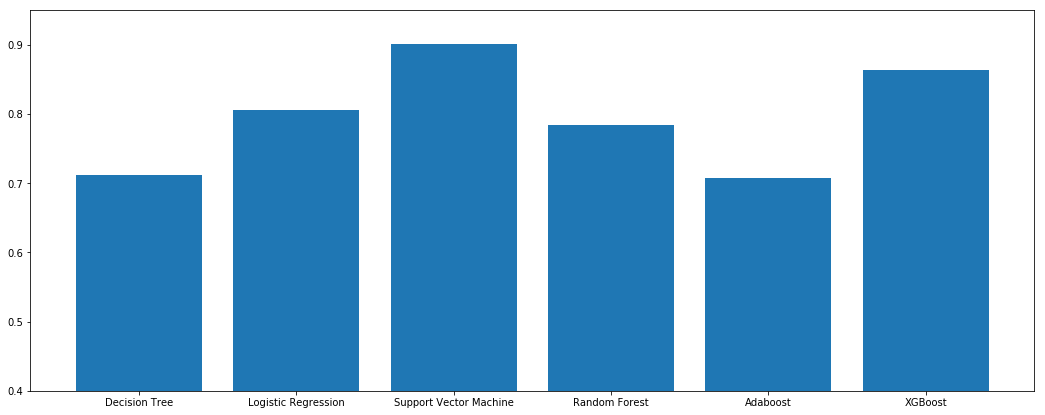

In [86]:
plt.figure(figsize=(18, 7))
plt.bar(results_df['Pipeline'], results_df['Top Score'])
plt.ylim(.4, .95)
plt.show()

In [87]:
from sklearn.metrics import accuracy_score

# For each model, print the accuracy score and classification report.
tree_preds = tree_gridsearch.predict(X_test)
tree_accuracy = accuracy_score(y_test, tree_preds)

logreg_preds = logreg_gridsearch.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_preds)

svm_preds = svm_gridsearch.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_preds)

rf_preds = rf_gridsearch.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

ada_preds = ada_gridsearch.predict(X_test)
ada_accuracy = accuracy_score(y_test, rf_preds)

xgb_preds = xgb_gridsearch.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)


# Generate model that calculates the weighted accuracy score of predictions. Weightings based on test set results.
tot_accuracies = tree_accuracy + logreg_accuracy + svm_accuracy + rf_accuracy + ada_accuracy + xgb_accuracy

overall_preds = np.round((np.array(tree_preds) * tree_accuracy +
                 np.array(logreg_preds) * logreg_accuracy +
                 np.array(svm_preds) * svm_accuracy +
                 np.array(rf_preds) * rf_accuracy + 
                 np.array(ada_preds) * ada_accuracy + 
                 np.array(xgb_preds) * xgb_accuracy) / tot_accuracies, 0).astype(int)

overall_accuracy = accuracy_score(y_test, overall_preds)

print(f'Decision Tree Accuracy: {tree_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, tree_preds)}\n')

print(f'Logistic Regression Accuracy: {logreg_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, logreg_preds)}\n')

print(f'Support Vector Machine Accuracy: {svm_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, svm_preds)}\n')

print(f'Random Forest Accuracy: {rf_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, rf_preds)}\n')

print(f'Adaboost Accuracy: {rf_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, ada_preds)}\n')

print(f'XGBoost Accuracy: {xgb_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, xgb_preds)}\n')

print(f'Combined Accuracy: {overall_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, overall_preds)}\n')

Decision Tree Accuracy: 72.93%
---------Classification Report---------
              precision    recall  f1-score   support

           1       0.81      0.83      0.82        52
           2       0.63      0.68      0.65        47
           3       0.76      0.65      0.70        34

   micro avg       0.73      0.73      0.73       133
   macro avg       0.73      0.72      0.72       133
weighted avg       0.73      0.73      0.73       133


Logistic Regression Accuracy: 76.69%
---------Classification Report---------
              precision    recall  f1-score   support

           1       0.85      0.90      0.88        52
           2       0.67      0.66      0.67        47
           3       0.75      0.71      0.73        34

   micro avg       0.77      0.77      0.77       133
   macro avg       0.76      0.76      0.76       133
weighted avg       0.76      0.77      0.76       133


Support Vector Machine Accuracy: 91.73%
---------Classification Report---------
        

<a id='modobvs'></a>
### Observations
The **XGBoost Model** yielded the best performance with an accuracy score of 89.47% when making predictions on unseen data. It also had the highest levels of precision and recall for high risk states at 93% and 78% respectively. 

However, the **Support Vector Machine Model** was much more efficient, performed better in cross validations, and performs with a high level of accuracy. As such, this model is preferred over **XGBoost** for making future predictions.

*Several attempts were made to combine models using weighted averages based on accuracy scores, however the results were far inferior to either of these models on their own.*

<a id='2019preds'></a>
## 2019 Predictions
Based on these results, the Support Vector Machine Model will be used to make predictions for 2019. All data associated will 2016 will be treated as 3 - 5 year lag data, and 2016 results will be compared with 2019 predictions.

In [88]:
# Create dataframe from 2016 data
pred_2019_df = lag_df[lag_df.columns[:-1]]
pred_2019_df = pred_2019_df[pred_2019_df.index.str[-4:]=='2016']
pred_2019_df['State_2019'] = pred_2019_df.index.str[:-5]
pred_2019_df = pred_2019_df.set_index('State_2019')
print(pred_2019_df.shape)
pred_2019_df.head()

(51, 162)


,Population_Male,Population_<_1_year,Population_1_4_years,Population_5_9_years,Population_10_14_years,Population_15_19_years,Population_20_24_years,Population_25_29_years,Population_30_34_years,Population_35_39_years,...,Population_75_79_years_lag_5,Population_80_84_years_lag_5,Population_85+_years_lag_5,Pop_Density_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,all_bevs_lag_5,Smoking_lag_5,Diabetes_lag_5
State_2019,,,,,,,,,,,,,,,,,,,,,
Alabama,-1.051999,-0.624540,-0.629633,-0.498151,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,...,0.263184,0.135407,-0.143233,-0.006250,-0.253356,-0.599801,-0.809918,-0.845177,0.543322,0.379440
Alaska,3.739304,1.200021,1.176875,0.740092,-0.200565,-1.317296,0.918602,2.157388,1.697301,-0.107274,...,-4.068908,-3.807296,-3.335340,-2.839803,-0.301499,0.946063,1.394341,0.944694,0.252051,-2.176276
Arizona,0.550417,-0.429601,-0.179050,0.023189,-0.237862,-0.593898,-0.085895,0.471467,-0.107045,-0.633062,...,0.229581,0.189955,0.004161,-0.339951,-0.301499,0.555666,0.170417,0.070854,-1.442760,0.424952
Arkansas,-0.173192,-0.131555,-0.094316,0.016329,-0.308263,-0.768788,-0.370142,0.149028,-0.405066,-0.664172,...,0.461729,0.269494,0.226763,-0.345314,-1.190978,-1.148205,-0.977935,-1.530376,0.726620,1.026870
California,0.515121,-0.346532,-0.174144,-0.170959,-0.577187,-0.910627,0.121316,1.472418,1.027240,0.048470,...,-1.138639,-0.616207,-0.040236,0.609805,-1.363857,1.082284,-0.168802,-0.222959,-1.892214,-0.776703


In [89]:
pred_2019_df.columns[27:]

Index(['Population_Male_lag_1', 'Population_<_1_year_lag_1',
       'Population_1_4_years_lag_1', 'Population_5_9_years_lag_1',
       'Population_10_14_years_lag_1', 'Population_15_19_years_lag_1',
       'Population_20_24_years_lag_1', 'Population_25_29_years_lag_1',
       'Population_30_34_years_lag_1', 'Population_35_39_years_lag_1',
       ...
       'Population_75_79_years_lag_5', 'Population_80_84_years_lag_5',
       'Population_85+_years_lag_5', 'Pop_Density_lag_5', 'beer_lag_5',
       'wine_lag_5', 'spirits_lag_5', 'all_bevs_lag_5', 'Smoking_lag_5',
       'Diabetes_lag_5'],
      dtype='object', length=135)

In [90]:
# Rename columns as lag identifiers (i.e. 2016 data represents a 3 year lag relative to 2019 predictions)
col_renames = {}

for col in pred_2019_df.columns[:27]:
    col_renames[col] = f'{col}_lag_3'

for col in pred_2019_df.columns[27:]:
    col_renames[col] = f'{col[:-1]}{int(col[-1])+3}'

pred_2019_df = pred_2019_df.rename(columns=col_renames)
pred_2019_df = pred_2019_df[pred_2019_df.columns[:-81]]
print(pred_2019_df.shape)
pred_2019_df.head()

(51, 81)


,Population_Male_lag_3,Population_<_1_year_lag_3,Population_1_4_years_lag_3,Population_5_9_years_lag_3,Population_10_14_years_lag_3,Population_15_19_years_lag_3,Population_20_24_years_lag_3,Population_25_29_years_lag_3,Population_30_34_years_lag_3,Population_35_39_years_lag_3,...,Population_75_79_years_lag_5,Population_80_84_years_lag_5,Population_85+_years_lag_5,Pop_Density_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,all_bevs_lag_5,Smoking_lag_5,Diabetes_lag_5
State_2019,,,,,,,,,,,,,,,,,,,,,
Alabama,-1.051999,-0.624540,-0.629633,-0.498151,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,...,0.600003,0.139909,0.093588,-0.000609,-0.399053,-0.521983,-0.650235,-0.796258,-0.061352,0.352235
Alaska,3.739304,1.200021,1.176875,0.740092,-0.200565,-1.317296,0.918602,2.157388,1.697301,-0.107274,...,-3.419421,-3.563390,-2.861940,-2.826746,-0.498350,0.874119,1.366705,0.824079,0.034256,-2.025151
Arizona,0.550417,-0.429601,-0.179050,0.023189,-0.237862,-0.593898,-0.085895,0.471467,-0.107045,-0.633062,...,0.776863,0.275536,0.310403,-0.315916,-0.158302,0.373978,0.129918,0.029951,-2.467164,0.730626
Arkansas,-0.173192,-0.131555,-0.094316,0.016329,-0.308263,-0.768788,-0.370142,0.149028,-0.405066,-0.664172,...,0.705545,0.303260,0.376505,-0.339492,-1.305632,-0.854350,-0.650235,-1.336209,0.534634,0.586359
California,0.515121,-0.346532,-0.174144,-0.170959,-0.577187,-0.910627,0.121316,1.472418,1.027240,0.048470,...,-0.816243,-0.657803,0.186022,0.627501,-1.078642,1.146910,-0.124393,-0.073836,-2.455796,-0.591149


<a id='2019results'></a>
### Results

In [91]:
svm_2019_preds = svm_gridsearch.predict(pred_2019_df)
pred_2019_df['SVM Predict'] = svm_2019_preds
pred_2019_df['SVM Predict']

State_2019
Alabama                 3
Alaska                  1
Arizona                 1
Arkansas                3
California              1
Colorado                1
Connecticut             2
Delaware                2
District of Columbia    2
Florida                 2
Georgia                 1
Hawaii                  1
Idaho                   1
Illinois                1
Indiana                 2
Iowa                    2
Kansas                  2
Kentucky                3
Louisiana               3
Maine                   2
Maryland                2
Massachusetts           2
Michigan                2
Minnesota               1
Mississippi             3
Missouri                3
Montana                 2
Nebraska                1
Nevada                  2
New Hampshire           2
New Jersey              2
New Mexico              1
New York                2
North Carolina          1
North Dakota            1
Ohio                    3
Oklahoma                1
Oregon                  1
P

In [92]:
get2016df = pd.read_csv('final_dataset.csv')
get2016df = get2016df[get2016df['State_Year'].str[-4:] == '2016'][['State_Year', 'Risk_Level']]

pred_2019_df['2016 Risk Level'] = np.array(get2016df['Risk_Level'])
pred_2019_df = pred_2019_df[['SVM Predict', '2016 Risk Level']]
pred_2019_df['Difference'] = pred_2019_df['SVM Predict'] - pred_2019_df['2016 Risk Level']
pred_2019_df[(pred_2019_df['Difference'] != 0)|(pred_2019_df['SVM Predict'] == 3)]

,SVM Predict,2016 Risk Level,Difference
State_2019,,,
Alabama,3,3,0
Arkansas,3,3,0
Illinois,1,2,-1
Kentucky,3,3,0
Louisiana,3,3,0
Maryland,2,1,1
Massachusetts,2,1,1
Michigan,2,3,-1
Mississippi,3,3,0


In [93]:
pred_2019_df.to_csv('2019_predictions.csv')

In [94]:
T1 = time.time()
tot_T = (T1 - T0) / 60
mins = int(tot_T)
secs = (tot_T - mins) * 60
print(f'Time to Complete: {mins}m {int(secs)}s')

Time to Complete: 10m 0s


In [95]:
smoking[smoking['State'] == 'Oklahoma'].to_csv('ok_smoking.csv')
smoking[smoking['State'] == 'Oklahoma']

,Year,State,Value,Estimated Adjustment,Adjusted Value
35,1999,Oklahoma,23.9,1.000000,23.900000
86,2000,Oklahoma,25.2,1.000000,25.200000
137,2001,Oklahoma,23.3,1.000000,23.300000
188,2002,Oklahoma,28.7,1.000000,28.700000
239,2003,Oklahoma,26.6,1.000000,26.600000
290,2004,Oklahoma,25.1,1.000000,25.100000
341,2005,Oklahoma,26.1,1.000000,26.100000
392,2006,Oklahoma,25.1,1.000000,25.100000
443,2007,Oklahoma,25.1,1.000000,25.100000
494,2008,Oklahoma,25.8,1.000000,25.800000


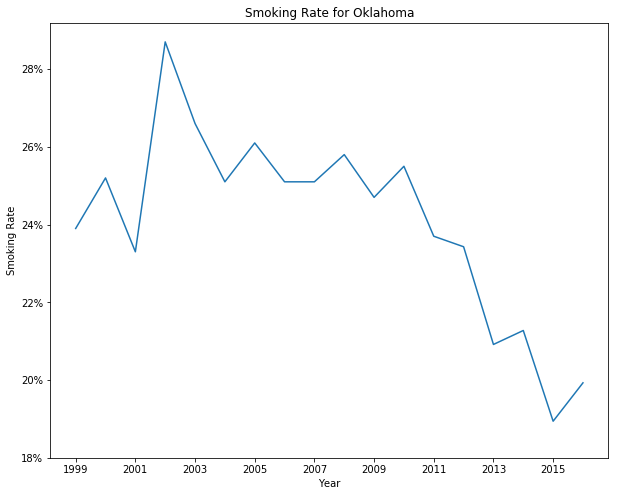

In [96]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(1999, 2017), smoking[smoking['State'] == 'Oklahoma']['Adjusted Value'])
plt.xticks(range(1999, 2017, 2))
plt.xlabel('Year')
plt.yticks(range(18, 30, 2), [f'{i}%' for i in range(18, 30, 2)])
plt.ylabel('Smoking Rate')
plt.title('Smoking Rate for Oklahoma')
plt.show()

<a id='concs'></a>
## Conclusions
<a id='concobvs'></a>
### Observations
Overall improvements in heart disease deaths are expected in 2019, with risk levels dropping for the following states:
* **Illinois**: Medium Risk to Low Risk
* **Michigan**: High Risk to Medium Risk
* **Oklahoma**: High Risk to Low Risk
* **Pennsylvania**: High Risk to Medium Risk

It is worth noting that Oklahoma had a significant drop in risk level, which appears due to a sharp reduction in smoking rates since 2010. 

Increased risk for:
* **Maryland**: Low Risk to Medium Risk
* **Massachusetts**: Low Risk to Medium Risk
* **Tennessee**: Medium Risk to High Risk

States that remain a high risk are the following:
* **Alabama**
* **Arkansas**
* **Kentucky**
* **Louisiana**
* **Mississippi**
* **Missouri**
* **Ohio**
* **West Virginia**
<a id='reco'></a>

### Recommendations
* Reallocate resources from states that have moved into the low-risk category (Illinois & Oklahoma) to high risk states.
* Run awareness campaigns that target women & the elderly to get regular checkups and screenings. The negative correlation between gender and population density indicates that women tend to represent a larger portion of the population high density regions. Campaigns in cities and urban are likely to be most cost effective when targeting women.
* Launch anti-smoking ad campaigns, as smoking is the most significant behavioral factor identified which impacts heart disease deaths.
<a id='next'></a>

### Next Steps

1. While certain behavioral factors can be useful in reducing risk for heart disease, demographic factors cannot be mitigated. For high risk states, it would be good to investigate the primary drivers of risk on a state-by-state basis because this will help inform a proper distribution of resources. For example, if the risk level is driven primarily by smoking habits, it might be useful to launch an ad campaign that attempts to get people to quit. However, if the risk level is driven primarily by an aging population, a specific focus on providing additional hospital support would be more appropriate.
2. At the moment, the only behavioral factor that seems to have a significant impact on risk level is smoking. Gathering additional data on habits related to diet and exercise should drive higher accuracy scores in the model, and will allow for more options related to resource distribution.
3. Perform similar analysis related to **Cancer** and other causes of death in effort to identify upcoming trends.